[View in Colaboratory](https://colab.research.google.com/github/jpskycak/research_notebooks/blob/master/360giving.ipynb)

This notebook details my analysis for the [360Giving challenge](https://challenge.threesixtygiving.org/). The goal is to identify

1) who has funded what themes throughout the years, and

2) for user-led organizations: who funds them, in what thematic area, how much funding to they receive and what type of organization are they (e.g. CIC, charity, co-operative, community group)?

# Data Prep (5/15)

In [0]:
!curl http://grantnav.threesixtygiving.org/api/grants.csv > grants.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  237M    0  237M    0     0  1170k      0 --:--:--  0:03:28 --:--:--  872k


I first organized the data, picking out columns that seemed informative and renaming them in a way that made sense to me.

In [0]:
import pandas as pd
df = pd.read_csv('grants.csv')

renaming = {'grant': [('Title','title'),
                      ('Description','description'),
                      ('Amount Applied For','request'),
                      ('Amount Awarded','award'),
                      ('Award Date','award_date'),
                      ('Planned Dates:Duration (months)','duration_months'),
                     ('Grant Programme:Title','type')],
           'recipient': [('Recipient Org:Name','name'),
                         ('Recipient Org:Charity Number','charity_number'),
                         ('Recipient Org:Company Number','company_number'),
                        ('Recipient Org:Postal Code','zip'),
                         ('Recipient Region','region'),
                         ('Recipient District','district'),
                         ('Recipient Ward','ward'),
                        ('Beneficiary Location:0:Country Code','country'),
                        ('Beneficiary Location:1:Name','location_highlevel'),
                        ('Beneficiary Location:2:Name','location_lowlevel')],
           'funder':[('Funding Org:Name','name'),
                    ('Funding Org:Postal Code','zip')]}

oldname_newname = {}
for k,vlist in renaming.iteritems():
  for vtuple in vlist:
    oldname = vtuple[0]
    newname = '_'.join([k,vtuple[1]])
    oldname_newname[oldname]=newname
    
df = df[oldname_newname.keys()].rename(index=str, columns=oldname_newname)

In [0]:
df.head()

,grant_type,recipient_location_lowlevel,recipient_location_highlevel,recipient_region,grant_request,recipient_name,recipient_ward,funder_name,grant_duration_months,grant_description,grant_award,recipient_charity_number,grant_award_date,grant_title,recipient_zip,recipient_district,funder_zip,recipient_country,recipient_company_number
0,Small Grants,Spelthorne,Spelthorne,South East Coast,NaN,Desborough Sailing Club,Shepperton Town Ward,Sport England,3.0,Funding under Sport England's Small Grants fun...,9686.0,NaN,2009-09-14T00:00:00+00:00,Members Boat Scheme,TW17 9LQ,Spelthorne District,NaN,GB,05099435
1,Small Grants,South Lakeland,Westmorland and Lonsdale,North West,NaN,The Brewery,Kendal Highgate Ward,Sport England,4.0,Funding under Sport England's Small Grants fun...,7480.0,1086789,2009-09-14T00:00:00+00:00,Boyz Sport Moves,LA9 4HE,South Lakeland District,NaN,GB,03927101
2,Small Grants,North Hertfordshire,North East Hertfordshire,East of England,NaN,Richard's Trampoline Club,Barton-le-Clay Ward,Sport England,12.0,Funding under Sport England's Small Grants fun...,7690.0,NaN,2009-09-14T00:00:00+00:00,"Growth, Sustain and Excel",MK45 4NF,Central Bedfordshire,NaN,GB,NaN
3,Small Grants,Chichester,Chichester,South East Coast,NaN,Chichester & Fishbourne Croquet Club,Fishbourne Ward,Sport England,1.0,Funding under Sport England's Small Grants fun...,6118.0,NaN,2009-09-14T00:00:00+00:00,New Lawn Mower,PO18 8BL,Chichester District,NaN,GB,NaN
4,Small Grants,Sedgemoor,Wells,South West,NaN,Berrow Short Mat Bowls Club,Berrow Ward,Sport England,12.0,Funding under Sport England's Small Grants fun...,1600.0,NaN,2009-09-14T00:00:00+00:00,Purchase of Bowls Mats,TA8 2QU,Sedgemoor District,NaN,GB,NaN


# Q1, First Iteration (5/15-5/17)

Then, I started to think about what the visualization should look like. I decided on a Strayer diagram mapping funders to themes, with thickness representing the total grant awards. I did a proof-of-concept using grant types as themes, and judged that this approach would be promising if I could reduce the grants to a smaller number of themes on the right-hand side.

In [0]:
grant_type_counts = df.grant_type.value_counts()
grant_types = grant_type_counts[grant_type_counts >= 10]
grant_types_filter = list(grant_types.index)

grant_filter = ((df.grant_award >= 10000) | df.grant_type.apply(lambda x: x in grant_types_filter))
df_grant_filter = df[grant_filter]
viz_df = df_grant_filter.groupby(['funder_name','grant_type']).sum()['grant_award'].reset_index()

funder_rankings = viz_df[['funder_name','grant_award']].groupby('funder_name').sum().sort_values('grant_award',ascending=False).reset_index().funder_name
type_rankings = viz_df[['grant_type','grant_award']].groupby('grant_type').sum().sort_values('grant_award',ascending=False).reset_index().grant_type
type_rankings.index += len(funder_rankings)
rankings = funder_rankings.append(type_rankings)

def nodenum(s):
  return list(rankings.index[rankings==s])[0]

import numpy as np
viz_df['Source']=viz_df.funder_name.apply(nodenum)
viz_df['Target'] = viz_df.grant_type.apply(nodenum)
viz_df['Color']='#262C46'
viz_df['Value']=viz_df['grant_award']#.apply(np.log10)

# https://plot.ly/~alishobeiri/1591/plotly-sankey-diagrams/#/
import plotly.plotly as py
py.sign_in('jpskycak','I6xndrZUDqf8sWKGmCIL')

data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
      thickness = 30,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label =  list(rankings),
      color = viz_df['Color']
    ),
    link = dict(
      source = viz_df['Source'],#.dropna(axis=0, how='any'),
      target = viz_df['Target'],#.dropna(axis=0, how='any'),
      value = viz_df['Value']#.dropna(axis=0, how='any'),
  )
)

layout =  dict(
    title = "Grants over $10,000\n or for Grant Types having 10+ Grants",
    height = 2000,
    width = 950,
    font = dict(
      size = 10
    ),    
)


fig = dict(data=[data_trace], layout=layout)
py.iplot(fig, validate=False)

I figured that the recipient name, grant type, grant tile, and grant description could help me categorize the grants into themes. Since they were extremely high-dimensional, I decided to reduce their dimensionality first. I did this by clustering each of the columns individually using k-means on its tf-idf matrix.

First, I created a tf-idf matrix for each column.

In [0]:
theme_cols = ['recipient_name','grant_type','grant_title','grant_description']
theme_df = df[theme_cols]

import nltk
nltk.download('words')
nltk.download('stopwords')
from nltk.corpus import words
from nltk.corpus import stopwords

%time permissible_words = dict.fromkeys([w for w in words.words() if w not in stopwords.words('english')], None)

def is_permissible(word):
    try:
        x = permissible_words[word]
        return True
    except KeyError:
        return False

def tokenize(s):
  try:
    tokens = s.lower().split()
    filtered_tokens = []
  
    for t in tokens:
      if len(t) >= 3: # quick filter
        if is_permissible(t):
          filtered_tokens.append(t)
            
    return filtered_tokens
  except:
    return []

for c in theme_df.columns:
  print 'tokenizing '+c+'...'
  %time theme_df[c+'_tokens'] = theme_df[c].apply(tokenize)
  %time theme_df[c+'_tokens_joined'] = theme_df[c+'_tokens'].apply(lambda x: ' '.join(x))
  print ''
theme_df.to_csv('theme_df.csv')
  
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizers = {c:TfidfVectorizer(max_df=0.8,min_df=0,stop_words='english',use_idf=True,tokenizer=tokenize, ngram_range=(1,3)) for c in theme_cols}
tfidf_matrices = {}
for c in theme_cols:
  print 'vectorizing '+c+'...'
  %time tfidf_matrices[c] = tfidf_vectorizers[c].fit_transform(theme_df[c+'_tokens_joined'].astype('U'))
  print 'shape:',tfidf_matrices[c].shape
  print ''

[nltk_data] Downloading package words to /content/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
CPU times: user 27.8 s, sys: 4.69 s, total: 32.5 s
Wall time: 32.6 s
tokenizing recipient_name...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


CPU times: user 1.76 s, sys: 63 ms, total: 1.83 s
Wall time: 1.82 s
CPU times: user 194 ms, sys: 7 ms, total: 201 ms
Wall time: 200 ms

tokenizing grant_type...
CPU times: user 1.3 s, sys: 35 ms, total: 1.33 s
Wall time: 1.33 s
CPU times: user 194 ms, sys: 2 ms, total: 196 ms
Wall time: 196 ms

tokenizing grant_title...
CPU times: user 1.8 s, sys: 57 ms, total: 1.86 s
Wall time: 1.85 s
CPU times: user 253 ms, sys: 9 ms, total: 262 ms
Wall time: 268 ms

tokenizing grant_description...
CPU times: user 11.1 s, sys: 195 ms, total: 11.3 s
Wall time: 11.3 s
CPU times: user 462 ms, sys: 21 ms, total: 483 ms
Wall time: 485 ms

vectorizing recipient_name...
CPU times: user 3.07 s, sys: 37 ms, total: 3.11 s
Wall time: 3.12 s
shape: (283077, 101837)

vectorizing grant_type...
CPU times: user 1.27 s, sys: 12 ms, total: 1.29 s
Wall time: 1.28 s
shape: (283077, 1739)

vectorizing grant_title...
CPU times: user 5.47 s, sys: 59 ms, total: 5.53 s
Wall time: 5.55 s
shape: (283077, 322315)

vectorizing g

In [0]:
theme_df.head()

,recipient_name,grant_type,grant_title,grant_description,recipient_name_tokens,recipient_name_tokens_joined,grant_type_tokens,grant_type_tokens_joined,grant_title_tokens,grant_title_tokens_joined,grant_description_tokens,grant_description_tokens_joined
0,Desborough Sailing Club,Small Grants,Members Boat Scheme,Funding under Sport England's Small Grants fun...,"[sailing, club]",sailing club,[small],small,"[boat, scheme]",boat scheme,"[sport, small, revenue, project, titled, boat,...",sport small revenue project titled boat projec...
1,The Brewery,Small Grants,Boyz Sport Moves,Funding under Sport England's Small Grants fun...,[brewery],brewery,[small],small,[sport],sport,"[sport, small, revenue, project, titled, sport...",sport small revenue project titled sport proje...
2,Richard's Trampoline Club,Small Grants,"Growth, Sustain and Excel",Funding under Sport England's Small Grants fun...,"[trampoline, club]",trampoline club,[small],small,"[sustain, excel]",sustain excel,"[sport, small, revenue, project, titled, susta...",sport small revenue project titled sustain pro...
3,Chichester & Fishbourne Croquet Club,Small Grants,New Lawn Mower,Funding under Sport England's Small Grants fun...,"[croquet, club]",croquet club,[small],small,"[new, lawn, mower]",new lawn mower,"[sport, small, revenue, project, titled, lawn,...",sport small revenue project titled lawn projec...
4,Berrow Short Mat Bowls Club,Small Grants,Purchase of Bowls Mats,Funding under Sport England's Small Grants fun...,"[short, mat, bowls, club]",short mat bowls club,[small],small,"[purchase, bowls]",purchase bowls,"[sport, small, revenue, project, titled, bowls...",sport small revenue project titled bowls proje...


Then, I performed k-means clustering within each tf-idf matrix. To choose the number of clusters, I used the elbow method for averages of repeated trials of 5, 10, 20, 40 clusters on a sample of the data.

In [0]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist
import random

n_clusters = [5,10,20,40]
n_repetitions = 10
km_models = {c:[KMeans(n_clusters=n) for n in n_clusters] for c in theme_cols}
km_distortions = {c:[] for c in theme_cols}

def sample_indices(X,n):
  shape = X.shape
  return (random.sample(range(shape[0]), min(shape[0],n)), random.sample(range(shape[1]), min(shape[1],n)))

def matrix_sample(X,sample):
  return X[sample[0],:][:,sample[1]]

def distortion(model, X, sample):
  return sum(np.min(cdist(X.toarray(), model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]

for c,model_list in km_models.iteritems():
  print 'computing for '+c+'...'
  for i,model in enumerate(model_list):
    print '   '+str(n_clusters[i])+' clusters...'
    for _ in range(n_repetitions):
      sample = sample_indices(tfidf_matrices[c],10000)
      X = matrix_sample(tfidf_matrices[c],sample)
      model.fit(X)
      km_distortions[c].append(distortion(model,X,sample))

computing for grant_title...
   5 clusters...
   10 clusters...
   20 clusters...
   40 clusters...
computing for grant_type...
   5 clusters...
   10 clusters...
   20 clusters...
   40 clusters...
computing for grant_description...
   5 clusters...
   10 clusters...
   20 clusters...
   40 clusters...
computing for recipient_name...
   5 clusters...
   10 clusters...
   20 clusters...
   40 clusters...


[]

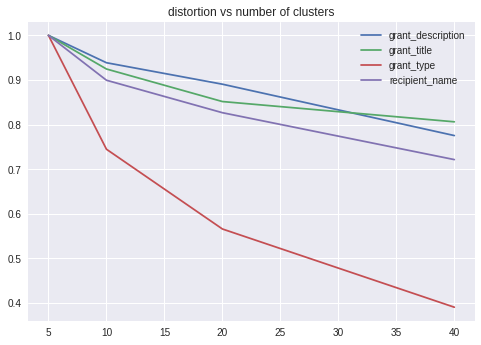

In [0]:
import matplotlib.pyplot as plt
import itertools

def unnest(nested):
  return [item for items in nested for item in items]

distortion_df = pd.DataFrame(km_distortions,index=unnest([[n]*n_repetitions for n in n_clusters]))
distortion_sums = distortion_df.groupby(by=distortion_df.index).sum()
distortion_sums_normalized = distortion_sums/distortion_sums.transpose()[5]
distortion_sums_normalized.plot(title='distortion vs number of clusters')
plt.plot()

Grant description and recipient name had elbows at 10 clusters, while grant title and grant type had elbows at 20 clusters. I clustered over the entire dataset, using these parameters. (All columns finish in 5 minutes or less except grant description, which takes about an hour.)

In [0]:
from sklearn.cluster import KMeans
import numpy as np
n_clusters = {'grant_description':10, 'recipient_name':10, 'grant_title':20, 'grant_type':20}
km_models = {c:KMeans(n_clusters=n_clusters[c]) for c in theme_cols}

for c,model in km_models.iteritems():
  print 'computing for '+c+'...'
  %time model.fit(tfidf_matrices[c])
  theme_df[c+'_cluster_number'] = model.labels_.tolist()
  theme_df.to_csv('theme_df.csv')
  print ''

computing for grant_title...
CPU times: user 4min 41s, sys: 34 ms, total: 4min 41s
Wall time: 4min 41s

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':




computing for grant_type...
CPU times: user 10.1 s, sys: 9 ms, total: 10.1 s
Wall time: 10.1 s

computing for grant_description...
CPU times: user 1h 2min 1s, sys: 1.22 s, total: 1h 2min 2s
Wall time: 1h 2min 2s

computing for recipient_name...
CPU times: user 1min 29s, sys: 21 ms, total: 1min 29s
Wall time: 1min 29s



I saved theme_df to persistent storage so that I wouldn't have to re-run the clustering once the colaboratory session expired.


In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
project_id = 'giving-challenge'
!gcloud config set project {project_id}
bucket_name = '360giving-challenge-data'
#!gsutil cp theme_df.csv gs://{bucket_name}/
!gsutil cp gs://{bucket_name}/theme_df.csv ~

Updated property [core/project].
Copying file://theme_df.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/204.4 MiB.                                    


Now, I can pick up the analysis from here:

In [0]:
import pandas as pd

theme_df = pd.read_csv('theme_df.csv')
del theme_df['Unnamed: 0']

import ast
def unstringify(x):
  if type(x)==str:
    return ast.literal_eval(x)
  else:
    return x

theme_cols = ['grant_description','recipient_name','grant_title','grant_type']
for c in theme_cols:
  theme_df[c+'_tokens'] = theme_df[c+'_tokens'].apply(unstringify)
  
theme_df.head()

,recipient_name,grant_type,grant_title,grant_description,recipient_name_tokens,recipient_name_tokens_joined,grant_type_tokens,grant_type_tokens_joined,grant_title_tokens,grant_title_tokens_joined,grant_description_tokens,grant_description_tokens_joined,grant_title_cluster_number,grant_type_cluster_number,grant_description_cluster_number,recipient_name_cluster_number
0,Desborough Sailing Club,Small Grants,Members Boat Scheme,Funding under Sport England's Small Grants fun...,"[sailing, club]",sailing club,[small],small,"[boat, scheme]",boat scheme,"[sport, small, revenue, project, titled, boat,...",sport small revenue project titled boat projec...,13,2,4,4
1,The Brewery,Small Grants,Boyz Sport Moves,Funding under Sport England's Small Grants fun...,[brewery],brewery,[small],small,[sport],sport,"[sport, small, revenue, project, titled, sport...",sport small revenue project titled sport proje...,13,2,4,4
2,Richard's Trampoline Club,Small Grants,"Growth, Sustain and Excel",Funding under Sport England's Small Grants fun...,"[trampoline, club]",trampoline club,[small],small,"[sustain, excel]",sustain excel,"[sport, small, revenue, project, titled, susta...",sport small revenue project titled sustain pro...,13,2,4,4
3,Chichester & Fishbourne Croquet Club,Small Grants,New Lawn Mower,Funding under Sport England's Small Grants fun...,"[croquet, club]",croquet club,[small],small,"[new, lawn, mower]",new lawn mower,"[sport, small, revenue, project, titled, lawn,...",sport small revenue project titled lawn projec...,13,2,4,4
4,Berrow Short Mat Bowls Club,Small Grants,Purchase of Bowls Mats,Funding under Sport England's Small Grants fun...,"[short, mat, bowls, club]",short mat bowls club,[small],small,"[purchase, bowls]",purchase bowls,"[sport, small, revenue, project, titled, bowls...",sport small revenue project titled bowls proje...,13,2,4,4


Then, I inspected the clusters for key words, in order to assign semantic labelings to the clusters.

In [0]:
from collections import Counter
import random
import numpy as np

n_clusters = {c:theme_df[c+'_cluster_number'].max()+1 for c in theme_cols}

def common_words(column,cluster_number):
  booleans = (theme_df[column+'_cluster_number']==cluster_number)
  clustersize = booleans.sum()
  sample = theme_df[booleans].sample(n=min(1000,clustersize))
  wordcounts = pd.Series(Counter(sample[column+'_tokens'].sum()))
  wordfreqs = wordcounts/wordcounts.sum()
  wordfreqs = wordfreqs[wordfreqs>0.05].sort_values(ascending=False).apply(lambda x: np.round(x,2))
  word_freq = [s.split() for s in str(wordfreqs).split('\n')][:-1]
  return ', '.join([pair[0]+' ('+pair[1]+')' for pair in word_freq])

def example(column,cluster_number):
  booleans = (theme_df[column+'_cluster_number']==cluster_number)
  all_examples = theme_df[booleans][column].unique()
  return str(random.choice(all_examples))

def readout(column):
  for n in range(n_clusters[column]):
    booleans = (theme_df[column+'_cluster_number']==n)
    clustersize = booleans.sum()
    print 'Cluster '+str(n)+' (size '+str(clustersize)+')'
    print 'Keywords | '+common_words(column,n)
    for _ in range(5):
      print '   '+example(column,n)
    print ' '

Recipient name had the following clusters:


* education - primary school (0)
* community (1)
* religious - parish (2)
* organization - individual (3)
* other (4) (too diverse to assign a semantic label)
* organization - limited (5)
* education - university/college (6, 8)
* education - high school (7)
* trust (9)




In [0]:
print readout('recipient_name')

Cluster 0 (size 12196)
Keywords | school (0.51), primary (0.42)
   Clapham Cof E Voluntary Controlled Primary School
   St. Benedicts RC School
   Sciennes Primary School
   Ferring C of E Primary School
   Friends of Osborne School
 
Cluster 1 (size 8957)
Keywords | association (0.34), community (0.33), cricket (0.11), club (0.11)
   Moco in the Community
   Killowen Community Association
   Pledwick Cricket Club
   SELNEC Association of Women's Clubs
   Chesham Tenants and Residents Association
 
Cluster 2 (size 7542)
Keywords | council (0.47), parish (0.19), borough (0.06), county (0.05), city (0.05)
   Waterperry with Thomley Parish Council
   Woodford Parish Council
   Fiskerton Parish Council
   Peakirk Parish Council
   Nuthall Parochial Church Council
 
Cluster 3 (size 20050)
Keywords | opposed (0.5), individual (0.5)
   Individual - Elicia Sanchez
   This is a programme for individual veterans as opposed to organisaitons
   Individual - Elicia Sanchez
   Individual - Favianna 

Grant type had the following clusters:


* other (0, 3, 7, 8, 9) (either too diverse or not informative keyword)
* veterans (1)
* size - small (2)
* northern ireland (4)
* community (5, 10)
* size - large (6)
* athletics (11, 16)
* celebration (12)
* size - medium (13)
* research - undergraduate (14)
* age - youth (15)
* scholarship - graduate (17)
* research - graduate (18)
* community - transport (19)




In [0]:
print readout('grant_type')

Cluster 0 (size 209922)
Keywords | 
   Southend Community Fund
   Reactive Grants
   IntegrationThrough Sport Fund
   Enable North
   Resettlement and Rehabilitation of Offenders
 
Cluster 1 (size 20154)
Keywords | return (1.0)
   Heroes Return
   Heroes Return
   Heroes Return
   Heroes Return
   Heroes Return
 
Cluster 2 (size 8410)
Keywords | small (1.0)
   Small Grants
   Small Grants Programme
   Education\Education - Small Grants
   Small Grants Programme
   CCF - Small Grants Programme
 
Cluster 3 (size 3413)
Keywords | home (0.34), recall (0.33), front (0.33)
   Home Front Recall
   Home Chargers 16/17
   Home Chargers 16/17
   Home Front Recall
   Home Chargers 16/17
 
Cluster 4 (size 6475)
Keywords | northern (1.0)
   Northern Ireland
   Northern Ireland
   Awards for All Northern Ireland
   Awards for All Northern Ireland
   Awards for All Northern Ireland
 
Cluster 5 (size 6823)
Keywords | reaching (1.0)
   Reaching Communities
   Reaching Communities
   Reaching Communitie

Grant title had the following clusters:


* other (0, 2, 3, 5, 9, 11, 13, 16, 18) (either too diverse or not informative keyword)
* education - primary school (1)
* community - village hall (4)
* equipment (6)
* none (7)
* health (8, 14)
* community (10)
* open access (12)
* community - transport (15)
* age - youth (17)
* garden (19)




In [0]:
readout('grant_title')

Cluster 0 (size 20055)
Keywords | return (1.0)
   Neighbourhood Return
   Lutonian CC - Return to Luton
   Return to Rugby 2015-16
   Lutonian CC - Return to Luton
   Werewolves of London return to Streatham
 
Cluster 1 (size 962)
Keywords | primary (0.66), school (0.21), grant (0.11)
   Newborough Primary School
   Grant to St Silas C of E Primary School
   St Oliver Plunkett Primary School
   Grant to Moulsecoomb Primary School
   Grant to Aragon Primary School PTA
 
Cluster 2 (size 509)
Keywords | street (0.41), party (0.26)
   60th anniversary street party
   Street Swords
   Street Sport
   Development of Street Pastors in Scotland
   Smilers @ High Street
 
Cluster 3 (size 1314)
Keywords | action (0.31), grant (0.14), community (0.06)
   Healthy & Happy Communities in Action
   Community Action Derby Website
   Mosborough Community Action Day
   Northern Action Against Suicide (NAAS)
   voluntary action orkney volunteer centre befriending network
 
Cluster 4 (size 2973)
Keywords 

Grant description had the following clusters:


* other (0, 1)
* community (2)
* education - primary (3)
* athletics (4, 8)
* veteran (5, 7)
* age - youth (6)
* none (9)




In [0]:
readout('grant_description')

Cluster 0 (size 150844)
Keywords | 
   This projects club aim to hold a holiday programme for children of 13 - 19 years. They believe the project will keep the youths of the streets as there is no provision of activities for people during the school holidays.
   This Market Harborough company will use an award to broadcast special monthly programmes in ten different villages in this rural area, providing information on services and showcasing music from different local arts. The project aims to reduce isolation and encourage a stronger sense of community.
   This project will deliver a Zumos programme to give pupils access to additional support aimed at improving their well-being.
   The Traveller community will better understand and contribute to planning policies that affect their way of life. They will meet planners and policy makers at seminars and forums to discuss issues including housing needs and resolving general misunderstanding and mistrust of authorities.
   Through funding

I relabeled the data according to semantic labels.

In [0]:
labeldict = {
    'recipient_name':{
        'education - primary school':[0],
        'community':[1],
        'religious - parish':[2],
        'organization - individual':[3],
        'other':[4],
        'organization - limited':[5],
        'education - university/college':[6,8],
        'education - high school':[7],
        'trust':[9]
    },
    'grant_type':{
        'other':[0,3,7,8,9],
        'veterans':[1],
        'size - small':[2],
        'northern ireland':[4],
        'community':[5,10],
        'size - large':[6],
        'athletics':[11,16],
        'celebration':[12],
        'size - medium':[13],
        'research - undergraduate':[14],
        'age - youth':[15],
        'scholarship - graduate':[17],
        'research - graduate':[18],
        'community - transport':[19]
    },
    'grant_title':{
        'other':[0, 2, 3, 5, 9, 11, 13, 16, 18],
        'education - primary school':[1],
        'community - village hall':[4],
        'equipment':[6],
        'none':[7],
        'health':[8,14],
        'community':[10],
        'open access':[12],
        'community - transport':[15],
        'age - youth':[17],
        'garden':[19]
    },
    'grant_description':{
        'other':[0,1],
        'community':[2],
        'education - primary':[3],
        'athletics':[4,8],
        'veteran':[5,7],
        'age - youth':[6],
        'none':[9]
    }
}

labeldict_forward = {c:{} for c in theme_cols}
for c in theme_cols:
  for label, cluster_numbers in labeldict[c].iteritems():
    for cluster_number in cluster_numbers:
      labeldict_forward[c][cluster_number] = label

for c in theme_cols:
  theme_df[c+'_cluster_label'] = theme_df[c+'_cluster_number'].apply(lambda x: labeldict_forward[c][x])
  
theme_df[[c+'_cluster_label' for c in theme_cols]].head()

,grant_description_cluster_label,recipient_name_cluster_label,grant_title_cluster_label,grant_type_cluster_label
0,athletics,other,other,size - small
1,athletics,other,other,size - small
2,athletics,other,other,size - small
3,athletics,other,other,size - small
4,athletics,other,other,size - small


I repeated the clustering process once more on the "other" labels.

In [0]:
import nltk
nltk.download('words')
nltk.download('stopwords')
from nltk.corpus import words
from nltk.corpus import stopwords

%time permissible_words = dict.fromkeys([w for w in words.words() if w not in stopwords.words('english')], None)

def is_permissible(word):
    try:
        x = permissible_words[word]
        return True
    except KeyError:
        return False

def tokenize(s):
  try:
    tokens = s.lower().split()
    filtered_tokens = []
  
    for t in tokens:
      if len(t) >= 3: # quick filter
        if is_permissible(t):
          filtered_tokens.append(t)
            
    return filtered_tokens
  except:
    return []
  
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizers = {c:TfidfVectorizer(max_df=0.8,min_df=0,stop_words='english',use_idf=True,tokenizer=tokenize, ngram_range=(1,3)) for c in theme_cols}
tfidf_matrices = {}
for c in theme_cols:
  print 'vectorizing '+c+'...'
  %time tfidf_matrices[c] = tfidf_vectorizers[c].fit_transform(theme_df[c+'_tokens_joined'][theme_df[c+'_cluster_label']=='other'].astype('U'))
  print 'shape:',tfidf_matrices[c].shape
  print ''

[nltk_data] Downloading package words to /content/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
CPU times: user 27.6 s, sys: 4.49 s, total: 32.1 s
Wall time: 32.1 s
vectorizing grant_description...
CPU times: user 35 s, sys: 1.13 s, total: 36.1 s
Wall time: 36.2 s
shape: (162748, 2574667)

vectorizing recipient_name...
CPU times: user 2.42 s, sys: 38 ms, total: 2.45 s
Wall time: 2.46 s
shape: (215980, 101279)

vectorizing grant_title...
CPU times: user 4.59 s, sys: 51 ms, total: 4.64 s
Wall time: 4.65 s
shape: (252727, 312280)

vectorizing grant_type...
CPU times: user 1.05 s, sys: 2 ms, total: 1.05 s
Wall time: 1.05 s
shape: (221511, 1727)



computing for grant_title...
   5 clusters...
   10 clusters...
   20 clusters...
   40 clusters...
computing for grant_type...
   5 clusters...
   10 clusters...
   20 clusters...
   40 clusters...
computing for grant_description...
   5 clusters...
   10 clusters...
   20 clusters...
   40 clusters...
computing for recipient_name...
   5 clusters...
   10 clusters...
   20 clusters...
   40 clusters...


[]

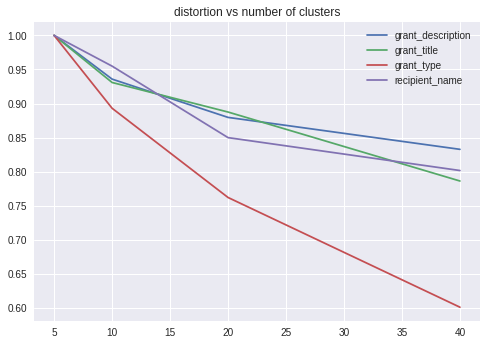

In [0]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist
import random

n_clusters = [5,10,20,40]
n_repetitions = 10
km_models = {c:[KMeans(n_clusters=n) for n in n_clusters] for c in theme_cols}
km_distortions = {c:[] for c in theme_cols}

def sample_indices(X,n):
  shape = X.shape
  return (random.sample(range(shape[0]), min(shape[0],n)), random.sample(range(shape[1]), min(shape[1],n)))

def matrix_sample(X,sample):
  return X[sample[0],:][:,sample[1]]

def distortion(model, X, sample):
  return sum(np.min(cdist(X.toarray(), model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]

for c,model_list in km_models.iteritems():
  print 'computing for '+c+'...'
  for i,model in enumerate(model_list):
    print '   '+str(n_clusters[i])+' clusters...'
    for _ in range(n_repetitions):
      sample = sample_indices(tfidf_matrices[c],10000)
      X = matrix_sample(tfidf_matrices[c],sample)
      model.fit(X)
      km_distortions[c].append(distortion(model,X,sample))

import matplotlib.pyplot as plt
import itertools

def unnest(nested):
  return [item for items in nested for item in items]

distortion_df = pd.DataFrame(km_distortions,index=unnest([[n]*n_repetitions for n in n_clusters]))
distortion_sums = distortion_df.groupby(by=distortion_df.index).sum()
distortion_sums_normalized = distortion_sums/distortion_sums.transpose()[5]
distortion_sums_normalized.plot(title='distortion vs number of clusters')
plt.plot()

In [0]:
from sklearn.cluster import KMeans
import numpy as np
n_clusters = {'grant_description':20, 'recipient_name':20, 'grant_title':10, 'grant_type':20}
km_models = {c:KMeans(n_clusters=n_clusters[c]) for c in theme_cols}

for c,model in km_models.iteritems():
  print 'computing for '+c+'...'
  %time model.fit(tfidf_matrices[c])
  theme_df[c+'_cluster_number_2'] = np.nan
  theme_df[c+'_cluster_number_2'][theme_df[c+'_cluster_label']=='other'] = model.labels_.tolist()
  theme_df.to_csv('theme_df.csv')
  print ''

computing for grant_title...
CPU times: user 4min 30s, sys: 66 ms, total: 4min 30s
Wall time: 4min 30s

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.




computing for grant_type...
CPU times: user 19.2 s, sys: 19 ms, total: 19.2 s
Wall time: 19.2 s

computing for grant_description...
CPU times: user 1h 23min 20s, sys: 3.16 s, total: 1h 23min 23s
Wall time: 1h 23min 23s

computing for recipient_name...
CPU times: user 2min 11s, sys: 34 ms, total: 2min 12s
Wall time: 2min 12s



In [0]:
theme_df.head()

,recipient_name,grant_type,grant_title,grant_description,recipient_name_tokens,recipient_name_tokens_joined,grant_type_tokens,grant_type_tokens_joined,grant_title_tokens,grant_title_tokens_joined,...,grant_description_cluster_number,recipient_name_cluster_number,grant_description_cluster_label,recipient_name_cluster_label,grant_title_cluster_label,grant_type_cluster_label,grant_title_cluster_number_2,grant_type_cluster_number_2,grant_description_cluster_number_2,recipient_name_cluster_number_2
0,Desborough Sailing Club,Small Grants,Members Boat Scheme,Funding under Sport England's Small Grants fun...,"[sailing, club]",sailing club,[small],small,"[boat, scheme]",boat scheme,...,4,4,athletics,other,other,size - small,5.0,NaN,NaN,1.0
1,The Brewery,Small Grants,Boyz Sport Moves,Funding under Sport England's Small Grants fun...,[brewery],brewery,[small],small,[sport],sport,...,4,4,athletics,other,other,size - small,5.0,NaN,NaN,15.0
2,Richard's Trampoline Club,Small Grants,"Growth, Sustain and Excel",Funding under Sport England's Small Grants fun...,"[trampoline, club]",trampoline club,[small],small,"[sustain, excel]",sustain excel,...,4,4,athletics,other,other,size - small,5.0,NaN,NaN,1.0
3,Chichester & Fishbourne Croquet Club,Small Grants,New Lawn Mower,Funding under Sport England's Small Grants fun...,"[croquet, club]",croquet club,[small],small,"[new, lawn, mower]",new lawn mower,...,4,4,athletics,other,other,size - small,5.0,NaN,NaN,15.0
4,Berrow Short Mat Bowls Club,Small Grants,Purchase of Bowls Mats,Funding under Sport England's Small Grants fun...,"[short, mat, bowls, club]",short mat bowls club,[small],small,"[purchase, bowls]",purchase bowls,...,4,4,athletics,other,other,size - small,5.0,NaN,NaN,15.0


In [0]:
from google.colab import auth
auth.authenticate_user()

project_id = 'giving-challenge'
!gcloud config set project {project_id}
bucket_name = '360giving-challenge-data'
#!gsutil cp theme_df.csv gs://{bucket_name}/
!gsutil cp gs://{bucket_name}/theme_df.csv ~

import pandas as pd

theme_df = pd.read_csv('theme_df.csv')
del theme_df['Unnamed: 0']

import ast
def unstringify(x):
  if type(x)==str:
    return ast.literal_eval(x)
  else:
    return x

theme_cols = ['grant_description','recipient_name','grant_title','grant_type']
for c in theme_cols:
  theme_df[c+'_tokens'] = theme_df[c+'_tokens'].apply(unstringify)
  
theme_df.head()

Updated property [core/project].
Copying gs://360giving-challenge-data/theme_df.csv...
\ [1 files][216.8 MiB/216.8 MiB]                                                
Operation completed over 1 objects/216.8 MiB.                                    


,recipient_name,grant_type,grant_title,grant_description,recipient_name_tokens,recipient_name_tokens_joined,grant_type_tokens,grant_type_tokens_joined,grant_title_tokens,grant_title_tokens_joined,...,grant_description_cluster_number,recipient_name_cluster_number,grant_description_cluster_label,recipient_name_cluster_label,grant_title_cluster_label,grant_type_cluster_label,grant_title_cluster_number_2,grant_type_cluster_number_2,grant_description_cluster_number_2,recipient_name_cluster_number_2
0,Desborough Sailing Club,Small Grants,Members Boat Scheme,Funding under Sport England's Small Grants fun...,"[sailing, club]",sailing club,[small],small,"[boat, scheme]",boat scheme,...,4,4,athletics,other,other,size - small,5.0,NaN,NaN,1.0
1,The Brewery,Small Grants,Boyz Sport Moves,Funding under Sport England's Small Grants fun...,[brewery],brewery,[small],small,[sport],sport,...,4,4,athletics,other,other,size - small,5.0,NaN,NaN,15.0
2,Richard's Trampoline Club,Small Grants,"Growth, Sustain and Excel",Funding under Sport England's Small Grants fun...,"[trampoline, club]",trampoline club,[small],small,"[sustain, excel]",sustain excel,...,4,4,athletics,other,other,size - small,5.0,NaN,NaN,1.0
3,Chichester & Fishbourne Croquet Club,Small Grants,New Lawn Mower,Funding under Sport England's Small Grants fun...,"[croquet, club]",croquet club,[small],small,"[new, lawn, mower]",new lawn mower,...,4,4,athletics,other,other,size - small,5.0,NaN,NaN,15.0
4,Berrow Short Mat Bowls Club,Small Grants,Purchase of Bowls Mats,Funding under Sport England's Small Grants fun...,"[short, mat, bowls, club]",short mat bowls club,[small],small,"[purchase, bowls]",purchase bowls,...,4,4,athletics,other,other,size - small,5.0,NaN,NaN,15.0


In [0]:
 from collections import Counter
import random
import numpy as np

n_clusters = {c:int(theme_df[c+'_cluster_number_2'].max()+1) for c in theme_cols}

def common_words(column,cluster_number):
  booleans = (theme_df[column+'_cluster_number_2']==cluster_number)
  clustersize = booleans.sum()
  sample = theme_df[booleans].sample(n=min(1000,clustersize))
  wordcounts = pd.Series(Counter(sample[column+'_tokens'].sum()))
  wordfreqs = wordcounts/wordcounts.sum()
  wordfreqs = wordfreqs[wordfreqs>0.05].sort_values(ascending=False).apply(lambda x: np.round(x,2))
  word_freq = [s.split() for s in str(wordfreqs).split('\n')][:-1]
  return ', '.join([pair[0]+' ('+pair[1]+')' for pair in word_freq])

def example(column,cluster_number):
  booleans = (theme_df[column+'_cluster_number_2']==cluster_number)
  all_examples = theme_df[booleans][column].unique()
  return str(random.choice(all_examples))

def readout(column):
  for n in range(n_clusters[column]):
    booleans = (theme_df[column+'_cluster_number_2']==n)
    clustersize = booleans.sum()
    print 'Cluster '+str(n)+' (size '+str(clustersize)+')'
    print 'Keywords | '+common_words(column,n)
    for _ in range(5):
      print '   '+example(column,n)
    print ' '

In [0]:
print readout('recipient_name')

Cluster 0 (size 25260)
Keywords | 
   Making Communities Work & Grow
   North Bristol Advice Centre
   Shared Lives Plus Limited
   CC Buzz
   Sister Ruben And Friends
 
Cluster 1 (size 9300)
Keywords | club (0.06)
   Moy Group Riding for the Disabled
   Veterans Scotland
   Shard End & Tile Cross Communities
   Kilkeel Sea Cadets
   Depaul UK
 
Cluster 2 (size 2487)
Keywords | 
   CHSUK
   Getaway Girls
   Canal Boat Adventure Project
   Bicester Athletic Club
   London Transport Museum, Covent Garden
 
Cluster 3 (size 5507)
Keywords | 
   The Graig WI
   RoaR
   Dudley Infant Academy
   South West Glasgow Carers Centre
   Garibaldi College
 
Cluster 4 (size 2952)
Keywords | 
   Ananda Ventures GmbH
   Boclair Academy
   Melrose Scout Group
   Creative Future
   Blackpool Boys & Girls Club
 
Cluster 5 (size 7219)
Keywords | 
   Barnsley Churches Drugs Project
   Three Villages Minibus
   Collingwood Over 60's Group
   Rushcliffe Community And Voluntary Service
   Whetstone Juniors Foo

In [0]:
print readout('grant_type')

Cluster 0 (size 160432)
Keywords | grant (0.08)
   Our Planet, Our Health (Planning)
   BaNES Community Wellness Fund Grant
   Datakind
   Jun 2014
   Wholesale / Blended - Key Fund
 
Cluster 1 (size 1242)
Keywords | grant (0.11)
   Investing in Communities
   Awards for All Scotland
   Themed Round 4
   Sportsmatch
   Research Resources Award
 
Cluster 2 (size 3504)
Keywords | grant (0.12), main (0.09)
   HoM Pilot Grant
   Innovation in Giving
   Digital R&D Fund
   Birmingham Youth Promise
   Research Resources Award
 
Cluster 3 (size 955)
Keywords | grant (0.12), fund (0.05)
   National Lottery Awards for All
   Further Education Activation Fund
   Sportsmatch
   Miscellaneous: Inactive scheme
   Jubilee People's Millions
 
Cluster 4 (size 2720)
Keywords | award (0.07), grant (0.06)
   Sustaining Health Award
   Research Resources Bursaries
   CCF - Main Grants Programme
   LA Majors 2016/17
   Global Health Trials Award
 
Cluster 5 (size 2409)
Keywords | main (0.09), grant (0.07),

In [0]:
print readout('grant_title')

Cluster 0 (size 14419)
Keywords | 
   Superheroes
   Tees Valley (Tees Valley Unlimited) Partnership Development Programme
   Ballinascreen Centre of Excellence
   Compton Parish Council Play Area Project
   Provide modern,well resourced focal point for the whole community to use
 
Cluster 1 (size 19077)
Keywords | return (0.07)
   Rights for Life: Rebuilding lives of marginalised families in post Tsunami
   Beyond Slavery
   Derrytrasna Community Audit
   Salary costs of the CEO
   Newton Park, Ayr
 
Cluster 2 (size 26787)
Keywords | grant (0.12)
   play equipment
   Haringey Rhinos Girls U15s team
   Exbury Egg (Artchitecture)
   Grant awarded to Chinese Association North East Region (Durham)
   Grant to After Adoption
 
Cluster 3 (size 4254)
Keywords | grant (0.13)
   Holme Lacy FC Reserve side funding 
   Grant to Eden Mencap Society
   Engine.
   Grant to Sea Squad Explorer Scout Unit, Wiltshire North Scouts, Corsham. 
   Wet and Wild Watchers
 
Cluster 4 (size 2419)
Keywords | 
 

In [0]:
print readout('grant_description')

Cluster 0 (size 7202)
Keywords | 
   Display in Brunel's Drawing Office
   The project is to establish a computer resource centre for the local community. The money is for computers, printers, marketing of facilities and equipment.
   This project will help to provide a multi court area to be used by groups and individuals for football, basketball and hockey. The wider project also includes provision of junior play equipment to help to improve physical skills and socialisation. The award is for a contribution towards a multi court surface
   a new Head of Business Development post
   A project by this charity based in Tavistock, Devon to improve the energy efficiency and lighting in their village hall.
 
Cluster 1 (size 366)
Keywords | 
   We are almost at our total fundraising goal to get the park installed and achieve one of the biggest community projects in Bourne!
   The group works to preserve the industrial and social history of the local area.   The award will be used to purchas

Keywords | 
   Support a scheme that saves lives in the Forth Valley area on a daily basis with vital funds for our vehicles, uniform and equipment.
   Grant to develop a new activity in student training, artistic development and public performance which will enhance the public profile, educational role and artistic range of Music Theatre Wales in Cardiff.
   This organisation gives one-to-one complementary therapy session, runs workshops and gives training to vulnerable adults and children, and their carers/parents. They would like funds for start-up costs to establish a solid infrastructure from which to offer their services.
   Teens and Toddlers pairs up disadvantaged teenagers with toddlers in a nursery whom they mentor. This program increases the aspirations, skills and self-esteem of the teenager and they gain a recognised qualification.
   Cued Speech is a simple sound-based system comprising eight handshapes, used in four positions near the mouth, in conjunction with the lip p

I didn't find any new semantic labels for clusters in any of the fields, which led me to believe that my earlier labelings were sufficient.

However, I noticed that some of the records in "other" should really belong to one of the earlier semantic labelings -- for example, there were schools which had been assigned to the "other" cluster rather than the "school" cluster.

I pivoted my strategy a bit, using the earlier semantic labels as a guide to generate tag lists from the fields, and themes from the tags.

In [0]:
themedict = {
    'education':['education - '+s for s in ['k-12','university/college','workshop']],
    'community':['community - '+s for s in ['uncategorized','transportation','religious','youth','elderly','maintenance','residential','heritage']],
    'social support':['social support - '+s for s in ['advocacy','welfare','inclusion']],
    'health':['health'],
    'athletics':['athletics'],
    'veterans':['veterans'],
    'celebration':['celebration'],
    'research':['research'],
    'trust/estate':['trust/estate'],
    'sustainability':['sustainability']
}

tagdict = {
    # education
    'education - k-12': ['school',' learn',' educat',' grade','academ','learn'],
    'education - university/college': ['universit','colleg','master',' ms','degree','doctor','phd','jd','md','scholar','fellow'],
    'education - workshop': ['workshop','class','course'],
    
    # community
    'community - uncategorized': ['communit'],
    'community - transportation': ['transport'],
    'community - religious': ['faith','religio','parish','church','mosque','temple','christ','buddh','hindu','jewish','judai','muslim','parochial'],
    'community - youth': ['scout','child','youth','cadet','boys','girls','day care','day centre','day center',' camp','young'],
    'community - elderly': ['older','elder','nursing'],
    'community - maintenance': ['garden','restor',' hall','refurbish','replace'],
    'community - residential': ['tenant','resident','landlord','homeowner'],
    'community - heritage': ['heritag','histor','preserv','archiv'],
    
    # social support
    'social support - advocacy': ['rights','aware','advoca','empower','minority','equality','racial'],
    'social support - welfare': ['homeless','underpriveleg','disadvantag','disabilit','refugee','welfare','soup','afford','in need'],
    'social support - inclusion': ['lonely','lonesome','isolat','interaction','exclusion','inclusion'],
    
    'health': ['health','suicide','treatment','hospital','wellness','well-being','wellbeing','drug','violence','autis','addict','abuse','trauma','counsel'],
    'athletics': ['sport','athlet','badminton','ball','soccer','polo','tennis','swim','cricket','facilit','pads','helmet','team','olympic','sail','court','hockey'],
    'veterans': ['home front','veteran',' war','memorial'],
    'celebration': ['celebrat'],
    'research': ['research','fellow','lab','gene','investigat','hypothes','organism','cell','study','phage','biol','modelling','modeling'],
    'trust/estate': ['trust','estate'],
    'sustainability': ['efficien','energ','renewable','environ','sustainab']
}

themedict_reversed = {}
for cat,taglist in themedict.iteritems():
  for tag in taglist:
    themedict_reversed[tag] = cat
    
tagdict_reversed = {}
for tag,wordlist in tagdict.iteritems():
  for word in wordlist:
    tagdict_reversed[word] = tag
    
def get_tags(s):
  out_tags = []
  for word,tag in tagdict_reversed.iteritems():
    if word in s:
      if tag not in out_tags:
        out_tags.append(tag)
  return out_tags

def get_themes(taglist):
  out_themes = []
  for t in taglist:
    theme = themedict_reversed[t]
    if theme not in out_themes:
      out_themes.append(theme)
  return out_themes

theme_df['all_tokens_joined'] = theme_df[[c+'_tokens_joined' for c in theme_cols]].apply(lambda x: ' | '.join([str(i) for i in x]),axis=1)
theme_df['tags'] = theme_df['all_tokens_joined'].apply(get_tags)
theme_df['themes'] = theme_df['tags'].apply(get_themes)

In [0]:
theme_df.head()

,recipient_name,grant_type,grant_title,grant_description,recipient_name_tokens,recipient_name_tokens_joined,grant_type_tokens,grant_type_tokens_joined,grant_title_tokens,grant_title_tokens_joined,...,recipient_name_cluster_label,grant_title_cluster_label,grant_type_cluster_label,grant_title_cluster_number_2,grant_type_cluster_number_2,grant_description_cluster_number_2,recipient_name_cluster_number_2,all_tokens_joined,tags,themes
0,Desborough Sailing Club,Small Grants,Members Boat Scheme,Funding under Sport England's Small Grants fun...,"[sailing, club]",sailing club,[small],small,"[boat, scheme]",boat scheme,...,other,other,size - small,5.0,NaN,NaN,1.0,sport small revenue project titled boat projec...,[athletics],[athletics]
1,The Brewery,Small Grants,Boyz Sport Moves,Funding under Sport England's Small Grants fun...,[brewery],brewery,[small],small,[sport],sport,...,other,other,size - small,5.0,NaN,NaN,15.0,sport small revenue project titled sport proje...,[athletics],[athletics]
2,Richard's Trampoline Club,Small Grants,"Growth, Sustain and Excel",Funding under Sport England's Small Grants fun...,"[trampoline, club]",trampoline club,[small],small,"[sustain, excel]",sustain excel,...,other,other,size - small,5.0,NaN,NaN,1.0,sport small revenue project titled sustain pro...,[athletics],[athletics]
3,Chichester & Fishbourne Croquet Club,Small Grants,New Lawn Mower,Funding under Sport England's Small Grants fun...,"[croquet, club]",croquet club,[small],small,"[new, lawn, mower]",new lawn mower,...,other,other,size - small,5.0,NaN,NaN,15.0,sport small revenue project titled lawn projec...,[athletics],[athletics]
4,Berrow Short Mat Bowls Club,Small Grants,Purchase of Bowls Mats,Funding under Sport England's Small Grants fun...,"[short, mat, bowls, club]",short mat bowls club,[small],small,"[purchase, bowls]",purchase bowls,...,other,other,size - small,5.0,NaN,NaN,15.0,sport small revenue project titled bowls proje...,[athletics],[athletics]


I checked to make sure my tags/themes covered most of the grants. They covered about 90%, which seemed good enough for me, at least at this stage.

In [0]:
1-theme_df.themes.apply(lambda x: x==[]).sum()/float(len(theme_df))

0.8846638900369864

I added the tags/themes columns to my main dataframe and checkpointed.

In [0]:
for c in ['tags','themes','all_tokens_joined']:
  df[c] = theme_df[c]

df.to_csv('df.csv')

In [0]:
from google.colab import auth
auth.authenticate_user()

project_id = 'giving-challenge'
!gcloud config set project {project_id}
bucket_name = '360giving-challenge-data'
#!gsutil cp df.csv gs://{bucket_name}/
!gsutil cp gs://{bucket_name}/df.csv ~

import pandas as pd

df = pd.read_csv('df.csv')
del df['Unnamed: 0']

import ast
def unstringify(x):
  if type(x)==str:
    return ast.literal_eval(x)
  else:
    return x

unstringify_cols = ['tags','themes']
for c in unstringify_cols:
  df[c] = df[c].apply(unstringify)
  
df.head()

Updated property [core/project].
Copying gs://360giving-challenge-data/df.csv...
- [1 files][188.5 MiB/188.5 MiB]                                                
Operation completed over 1 objects/188.5 MiB.                                    


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,15,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,grant_type,recipient_location_lowlevel,recipient_location_highlevel,recipient_region,grant_request,recipient_name,recipient_ward,funder_name,grant_duration_months,grant_description,...,grant_award_date,grant_title,recipient_zip,recipient_district,funder_zip,recipient_country,recipient_company_number,tags,themes,all_tokens_joined
0,Small Grants,Spelthorne,Spelthorne,South East Coast,NaN,Desborough Sailing Club,Shepperton Town Ward,Sport England,3.0,Funding under Sport England's Small Grants fun...,...,2009-09-14T00:00:00+00:00,Members Boat Scheme,TW17 9LQ,Spelthorne District,NaN,GB,05099435,[athletics],[athletics],sport small revenue project titled boat projec...
1,Small Grants,South Lakeland,Westmorland and Lonsdale,North West,NaN,The Brewery,Kendal Highgate Ward,Sport England,4.0,Funding under Sport England's Small Grants fun...,...,2009-09-14T00:00:00+00:00,Boyz Sport Moves,LA9 4HE,South Lakeland District,NaN,GB,03927101,[athletics],[athletics],sport small revenue project titled sport proje...
2,Small Grants,North Hertfordshire,North East Hertfordshire,East of England,NaN,Richard's Trampoline Club,Barton-le-Clay Ward,Sport England,12.0,Funding under Sport England's Small Grants fun...,...,2009-09-14T00:00:00+00:00,"Growth, Sustain and Excel",MK45 4NF,Central Bedfordshire,NaN,GB,NaN,[athletics],[athletics],sport small revenue project titled sustain pro...
3,Small Grants,Chichester,Chichester,South East Coast,NaN,Chichester & Fishbourne Croquet Club,Fishbourne Ward,Sport England,1.0,Funding under Sport England's Small Grants fun...,...,2009-09-14T00:00:00+00:00,New Lawn Mower,PO18 8BL,Chichester District,NaN,GB,NaN,[athletics],[athletics],sport small revenue project titled lawn projec...
4,Small Grants,Sedgemoor,Wells,South West,NaN,Berrow Short Mat Bowls Club,Berrow Ward,Sport England,12.0,Funding under Sport England's Small Grants fun...,...,2009-09-14T00:00:00+00:00,Purchase of Bowls Mats,TA8 2QU,Sedgemoor District,NaN,GB,NaN,[athletics],[athletics],sport small revenue project titled bowls proje...


To create visualizations, I had to remove entries with no tags/themes and expand out entries with multiple tags/themes. This took a while so I checkpointed again.

In [0]:
viz_df = df[['funder_name','grant_award','themes','tags']]
nonempty = viz_df['themes'].apply(lambda x: x!=[])
viz_df = viz_df[nonempty]

themes = viz_df.apply(lambda x: pd.Series(x['themes']),axis=1).stack().reset_index(level=1, drop=True)
tags = viz_df.apply(lambda x: pd.Series(x['tags']),axis=1).stack().reset_index(level=1, drop=True)
themes.name = 'theme'
tags.name = 'tag'

viz_df = viz_df.drop(['themes','tags'], axis=1).join(themes).join(tags)
viz_df.to_csv('viz_df.csv')
viz_df.head()

,funder_name,grant_award,theme,tag
0,Sport England,9686.0,athletics,athletics
1,Sport England,7480.0,athletics,athletics
2,Sport England,7690.0,athletics,athletics
3,Sport England,6118.0,athletics,athletics
4,Sport England,1600.0,athletics,athletics


In [0]:
from google.colab import auth
import pandas as pd
auth.authenticate_user()

project_id = 'giving-challenge'
!gcloud config set project {project_id}
bucket_name = '360giving-challenge-data'
#!gsutil cp viz_df.csv gs://{bucket_name}/
!gsutil cp gs://{bucket_name}/viz_df.csv ~

viz_df = pd.read_csv('viz_df.csv')
del viz_df['Unnamed: 0']
viz_df.head()

Updated property [core/project].
Copying gs://360giving-challenge-data/viz_df.csv...
- [1 files][ 69.1 MiB/ 69.1 MiB]                                                
Operation completed over 1 objects/69.1 MiB.                                     


,funder_name,grant_award,theme,tag
0,Sport England,9686.0,athletics,athletics
1,Sport England,7480.0,athletics,athletics
2,Sport England,7690.0,athletics,athletics
3,Sport England,6118.0,athletics,athletics
4,Sport England,1600.0,athletics,athletics


In [0]:
rhs_column = 'theme'
viz_df_agg = viz_df.groupby(['funder_name',rhs_column]).sum()['grant_award'].reset_index()
booleans = (viz_df_agg['grant_award'] >= 10000)
viz_df_agg = viz_df_agg[booleans]

funder_rankings = viz_df_agg[['funder_name','grant_award']].groupby('funder_name').sum().sort_values('grant_award',ascending=False).reset_index()['funder_name']
rhs_rankings = viz_df_agg[[rhs_column,'grant_award']].groupby(rhs_column).sum().sort_values('grant_award',ascending=False).reset_index()[rhs_column]
rhs_rankings.index += len(funder_rankings)
rankings = funder_rankings.append(rhs_rankings)

def nodenum(s):
  return list(rankings.index[rankings==s])[0]

import numpy as np
viz_df_agg['Source']=viz_df_agg['funder_name'].apply(nodenum)
viz_df_agg['Target'] = viz_df_agg[rhs_column].apply(nodenum)
viz_df_agg['Color']='#262C46'
viz_df_agg['Value']=viz_df_agg['grant_award']#.apply(np.log10)

# https://plot.ly/~alishobeiri/1591/plotly-sankey-diagrams/#/
import plotly.plotly as py
py.sign_in('jpskycak','I6xndrZUDqf8sWKGmCIL')

data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
      thickness = 30,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label =  list(rankings),
      color = viz_df_agg['Color']
    ),
    link = dict(
      source = viz_df_agg['Source'],#.dropna(axis=0, how='any'),
      target = viz_df_agg['Target'],#.dropna(axis=0, how='any'),
      value = viz_df_agg['Value']#.dropna(axis=0, how='any'),
  )
)

layout =  dict(
    title = "Funders & Themes ($10,000+)",
    height = 1500,
    width = 950,
    font = dict(
      size = 10
    ),    
)


fig = dict(data=[data_trace], layout=layout)
py.iplot(fig, validate=False)

The plot was messy, so I restricted it to the largest funders.

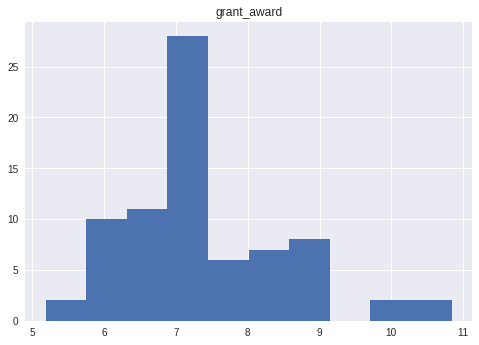

In [0]:
import matplotlib.pyplot as plt
viz_df_agg[['funder_name','grant_award']].groupby('funder_name').sum().apply(np.log10).hist()
plt.show()

In [0]:
rhs_column = 'theme'
viz_df_agg = viz_df.groupby(['funder_name',rhs_column]).sum()['grant_award'].reset_index()
booleans = (viz_df_agg['grant_award'] <= 1000000)
viz_df_agg = viz_df_agg[booleans]

funder_rankings = viz_df_agg[['funder_name','grant_award']].groupby('funder_name').sum().sort_values('grant_award',ascending=False).reset_index()['funder_name']
rhs_rankings = viz_df_agg[[rhs_column,'grant_award']].groupby(rhs_column).sum().sort_values('grant_award',ascending=False).reset_index()[rhs_column]
rhs_rankings.index += len(funder_rankings)
rankings = funder_rankings.append(rhs_rankings)

def nodenum(s):
  return list(rankings.index[rankings==s])[0]

import numpy as np
viz_df_agg['Source']=viz_df_agg['funder_name'].apply(nodenum)
viz_df_agg['Target'] = viz_df_agg[rhs_column].apply(nodenum)
viz_df_agg['Color']='#262C46'
viz_df_agg['Value']=viz_df_agg['grant_award']#.apply(np.log10)

# https://plot.ly/~alishobeiri/1591/plotly-sankey-diagrams/#/
import plotly.plotly as py
py.sign_in('jpskycak','I6xndrZUDqf8sWKGmCIL')

data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
      thickness = 30,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label =  list(rankings),
      color = viz_df_agg['Color']
    ),
    link = dict(
      source = viz_df_agg['Source'],#.dropna(axis=0, how='any'),
      target = viz_df_agg['Target'],#.dropna(axis=0, how='any'),
      value = viz_df_agg['Value']#.dropna(axis=0, how='any'),
  )
)

layout =  dict(
    title = "Small Funders (under $1m) & Themes",
    height = 1500,
    width = 950,
    font = dict(
      size = 10
    ),    
)


fig = dict(data=[data_trace], layout=layout)
py.iplot(fig, validate=False)

In [0]:
rhs_column = 'theme'
viz_df_agg = viz_df.groupby(['funder_name',rhs_column]).sum()['grant_award'].reset_index()
booleans = (viz_df_agg['grant_award'] >= 100000000)
viz_df_agg = viz_df_agg[booleans]

funder_rankings = viz_df_agg[['funder_name','grant_award']].groupby('funder_name').sum().sort_values('grant_award',ascending=False).reset_index()['funder_name']
rhs_rankings = viz_df_agg[[rhs_column,'grant_award']].groupby(rhs_column).sum().sort_values('grant_award',ascending=False).reset_index()[rhs_column]
rhs_rankings.index += len(funder_rankings)
rankings = funder_rankings.append(rhs_rankings)

def nodenum(s):
  return list(rankings.index[rankings==s])[0]

import numpy as np
viz_df_agg['Source']=viz_df_agg['funder_name'].apply(nodenum)
viz_df_agg['Target'] = viz_df_agg[rhs_column].apply(nodenum)
viz_df_agg['Color']='#262C46'
viz_df_agg['Value']=viz_df_agg['grant_award']

# https://plot.ly/~alishobeiri/1591/plotly-sankey-diagrams/#/
import plotly.plotly as py
py.sign_in('jpskycak','I6xndrZUDqf8sWKGmCIL')

data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
      thickness = 30,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label =  list(rankings),
      color = viz_df_agg['Color']
    ),
    link = dict(
      source = viz_df_agg['Source'],#.dropna(axis=0, how='any'),
      target = viz_df_agg['Target'],#.dropna(axis=0, how='any'),
      value = viz_df_agg['Value']#.dropna(axis=0, how='any'),
  )
)

layout =  dict(
    title = "Large Funders (over $100m) & Themes",
    height = 1000,
    width = 950,
    font = dict(
      size = 10
    ),    
)


fig = dict(data=[data_trace], layout=layout)
py.iplot(fig, validate=False)

The plot still didn't look too informative.

Idea: I'll create an embedding using the percentage profiles of funders (e.g. 20% to education, 60% to community, 20% to athletics) and make the dot size reflect the total amount of funding. When the user hovers over a dot, they see the profile and amount funded. Then the user can choose which themes to include in the visualization. Can support more granular themes too (e.g. the subcategories within education or community).

Try PCA, then t-SNE

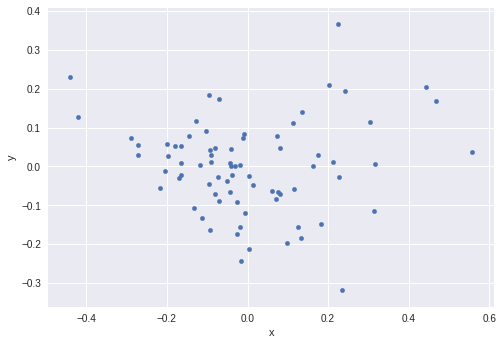

In [0]:
viz_df_agg = viz_df.groupby(['funder_name','theme']).sum()['grant_award'].reset_index()
dummies = pd.get_dummies(viz_df_agg['theme'])
vectors = dummies.mul(viz_df_agg['grant_award'], axis=0)
vectors['funder_name'] = viz_df_agg['funder_name']
vectors = vectors.groupby('funder_name').sum()
vectors = vectors.div(vectors.sum(axis=1), axis=0)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca = pca.fit_transform(vectors)
pca_df = pd.DataFrame(data = pca, columns = ['x', 'y'])
pca_df.index = vectors.index

import matplotlib.pyplot as plt
pca_df.plot.scatter(x='x',y='y')
plt.show()

The x-axis represents community <---> education

The y-axis represents health/research/social support <----> education/community

In [0]:
pd.concat([vectors[pca_df.x<-0.2].mean(), vectors[pca_df.x>0.2].mean(), vectors[pca_df.y<-0.15].mean(), vectors[pca_df.y>0.15].mean()],axis=1)

,0,1,2,3
athletics,0.154522,0.024186,0.048034,0.034354
celebration,0.000000,0.000046,0.000431,0.000000
community,0.584704,0.168587,0.222857,0.366614
education,0.029363,0.402145,0.089293,0.404948
health,0.086571,0.047725,0.180874,0.018561
research,0.012295,0.204539,0.137838,0.062281
social support,0.030717,0.033668,0.185631,0.024885
sustainability,0.025352,0.037767,0.062266,0.002138
trust/estate,0.059476,0.078649,0.069393,0.085627
veterans,0.017000,0.002689,0.003383,0.000592


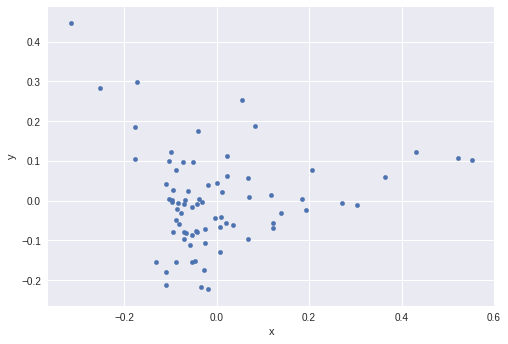

In [0]:
viz_df_agg = viz_df.groupby(['funder_name','tag']).sum()['grant_award'].reset_index()
dummies = pd.get_dummies(viz_df_agg['tag'])
vectors = dummies.mul(viz_df_agg['grant_award'], axis=0)
vectors['funder_name'] = viz_df_agg['funder_name']
vectors = vectors.groupby('funder_name').sum()
vectors = vectors.div(vectors.sum(axis=1), axis=0)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca = pca.fit_transform(vectors)
pca_df = pd.DataFrame(data = pca, columns = ['x', 'y'])
pca_df.index = vectors.index

import matplotlib.pyplot as plt
pca_df.plot.scatter(x='x',y='y')
plt.show()

The x-axis represents community - youth <---> education - university/college

The y-axis represents health/research/social support <----> ???

In [0]:
pd.concat([vectors[pca_df.x<-0.1].mean(), vectors[pca_df.x>0.2].mean(), vectors[pca_df.y<-0.1].mean(), vectors[pca_df.y>0.1].mean()],axis=1)

,0,1,2,3
athletics,0.089179,0.022308,0.077702,0.057166
celebration,0.000801,0.000072,0.002325,0.000009
community - elderly,0.019282,0.010449,0.091387,0.005430
community - heritage,0.001707,0.074866,0.006444,0.028856
community - maintenance,0.020255,0.010727,0.029783,0.018825
community - religious,0.009484,0.000348,0.009895,0.006931
community - residential,0.008967,0.000825,0.007605,0.002976
community - transportation,0.003060,0.010851,0.047101,0.002604
community - uncategorized,0.143495,0.008681,0.209672,0.030615
community - youth,0.307446,0.023111,0.063072,0.291054


This looks alright. The next step would be to scale the bubbles with funding size and show the distributions when you hover over -- maybe something with plotly. First, I'll work on improving the themes/tags.


# Q1, Second Iteration (5/17-5/19)

My stretegy to expand the tags was to iteratively ask "what are the most common words that I haven't considered yet?" and sort them into either new tags or put them on an "ignore" list. It worked wonderfully and I ended up with a nice, full tag hierarchy after about two hours of manual iteration.

I also thought of a better way to present the data: I could make a search interface that allowed users to input a query "who were the {top funders | most focused funders} in themes {theme list - checkbox}" from year {startyear} to year {endyear}?". (Focused funders = those that concentrate their funding in a particular category.) The end result would be something like .http://www.datavizchallenge.org/viz/56.

In [0]:
tagdict = {
    'education - uncategorized': ['learn','educat','academ','class','course','student'],
    'education - k-12': ['school',' grade'],
    'education - university/college': ['universit','colleg','master',' ms','degree','doctor','phd','jd','md','scholar','fellow','institut'],
    'education - workshop': ['workshop','train'],
    
    'community - uncategorized': ['communit','local','district','town','village','county','city','borough'],
    'community - transportation': ['transport'],
    'community - religious': ['faith','religio','parish','church','mosque','temple','christ','buddh','hindu','jewish','judai','muslim','parochial'],
    'community - youth': ['mentor','scout','child','youth','cadet','boys','girls','day care','day centre','day center',' camp','young'],
    'community - elderly': ['older','elder','nursing'],
    'community - maintenance': ['garden','restor',' hall','refurbish','replace'],
    'community - residential': ['tenant','resident','landlord','homeowner'],
    'community - heritage': ['heritag','histor','preserv','archiv'],
    
    'social support - equality/inclusion': ['rights','aware','advoca','empower','minority','equality','racial','lonely','lonesome','isolat',
                                            'interaction','exclusion','inclusion','confiden','access','refugee''underpriveleg','disadvantag'],
    'social support - welfare': ['homeless','welfare','soup','afford','aid','relief'],
    'social support - social work': ['violen','trauma','abuse'],
    'social support - disability': ['disabilit','disabl','autis','alzheim','special-needs','special needs'],
    
    'event - uncategorized': ['food','drink','venue','event','attend','host'],
    'event - travel': ['travel','visit'],
    'event - converence': ['conference'],
    'event - commemorative': ['celebrat','commemor','festival','memorial','anniversar'],
    'event - cultural':['cultur'],
    
    'organization type - individual': ['individual'],
    'organization type - group':['organization','group','association','council','society','committee'],
    'organization type - charity':['charity','foundation'],
    'organization type - business':['company','business','enterprise'],
    'organization type - trust/estate':['trust','estate'],
    
    'recreation - uncategorized':['recreation','hobby'],
    'recreation - athletics': ['dance','coach','sport','athlet','badminton','ball','soccer','polo','tennis','swim','cricket',
                               'olympic','sail','court','hockey','bowling'],
    'recreation - arts': [' art','paint','music','dance','creative','drama'],
    'recreation - volunteer':['volunteer'],
    
    'science/technology - uncategorized': ['research','fellow','investigat','hypothes','study','science','computer','digital','technolog','royal',
                                          'data','modelling','modeling','novel','analysis','analytic'],
    'science/technology - life science': ['lab','gene','organism','cell','phage','biol','molecul','protein'],
    'science/technology - social science': ['economic','sociol'],
    'science/technology - computing':['computing','computational','numeric'],
    'science/technology - sustainability': ['efficien','energ','renewable','environ','sustainab','green','nature','forest','tree','recycl','conserv'],
    
    'health - uncategorized': ['health','treatment','hospital','wellness','well-being','wellbeing','clinical','medic','disease','therap'],
    'health - mental health': ['suicide','drug','addict','counsel','mental','violent','trauma','abuse','disorder'],
    'health - physical health': ['fitness','exercise'],
    
    'employment': ['employee','salary','hire'],
    
    'veterans': ['home front','veteran',' war'],
    'equipment': ['equip','upgrad']
}

In [0]:
def unlist(x):
  return [item for sublist in x for item in sublist]

tagstems = unlist(tagdict.values())

def has_stem(token):
  output = False
  for stem in tagstems:
    if stem in token:
      output = True
      break
  return output

uninformative_stems = ['club','nan','project','grant','people','work',
                      'use','provide','towards','return','new','support',
                      'improve','primary','also','develo','enable','war',
                      'second','fund','activity','world','social','main',
                      'opposed','small','help','one','area','run','titled',
                      'hall','increase','outdoor','deliver','purchase',
                      'service','life','village','advice','record','revenue',
                      'range','sessions','care','name','family','based','two',
                      'aim','north','limited','take','information','allow','action',
                      'create','living','west','build','within','national',
                      'include','park','offer','would','well','install','provid',
                      'day','encourag','public','east','togeth','pay','make','home',
                      'part','south','promote','voluntary','focus','benefit','high',
                      'needs','reduce','reaching','three','open','year','series','first',
                      'set','active','provision','safe','engage','better','capacity',
                      'opportunity','human','employment','improv','event','across',
                      'quality','aged','role','hold','scheme','may','safe','different',
                      'system','understanding','staff','capital','art','time','establish',
                      'food','current','addition','space','bring','summer','age','core',
                      'kitchen','order','key','around','june','able','rural','positive',
                      'raise','place','future','junior','inspire','extend','experience',
                      'fun','continue','large','number','meet','housing','special','self',
                      'involved','identify','become','plan','risk','give','front','get',
                      'produce','film','ensure','early','free','mak','room','outreach',
                      'old','forum','expand','increas','various','week','profession',
                      'potential','associated','need','gain','enhance','resource','domestic',
                      'lottery','need','water','interest','nursery','impact','end','recall',
                      'personal','street','address','variety','play','pilot','adult','four',
                      'cost','specific','pitch','physical','facilit','team']
def is_uninformative(token):
  output = False
  for stem in uninformative_stems:
    if stem in token:
      output = True
      break
  return output

def filter_out(s):
  outlist = []
  
  tokens = s.replace(' | ',' ').split()
  for t in tokens:
    if not is_uninformative(t):
      if not has_stem(t):
        outlist.append(t)
  return outlist

remaining_words = df['all_tokens_joined'].sample(n=10000).apply(filter_out).sum()

from collections import Counter
pd.Series(Counter(remaining_words)).sort_values(ascending=False).head(20)

many             137
sessional        125
cancer           120
field            119
greater          117
reducing         114
trip             114
explore          112
knowledge        112
lead             110
model            109
toilet           109
live             108
buy              108
communication    106
production       106
library          105
design           105
central          104
parent           103
dtype: int64

In [0]:
tagdict_reversed = {}
for tag,wordlist in tagdict.iteritems():
  for word in wordlist:
    tagdict_reversed[word] = tag
    
def get_tags(s):
  out_tags = []
  for word,tag in tagdict_reversed.iteritems():
    if word in s:
      if tag not in out_tags:
        out_tags.append(tag)
  return out_tags

In [0]:
% time df['tags'] = df['all_tokens_joined'].apply(get_tags)
df.to_csv('df.csv')

CPU times: user 14.9 s, sys: 16 ms, total: 14.9 s
Wall time: 15 s


In [0]:
from google.colab import auth
auth.authenticate_user()

project_id = 'giving-challenge'
!gcloud config set project {project_id}
bucket_name = '360giving-challenge-data'
#!gsutil cp df.csv gs://{bucket_name}/
!gsutil cp gs://{bucket_name}/df.csv ~

import pandas as pd

df = pd.read_csv('df.csv')
del df['Unnamed: 0']

import ast
def unstringify(x):
  if type(x)==str:
    return ast.literal_eval(x)
  else:
    return x

unstringify_cols = ['tags','themes']
for c in unstringify_cols:
  df[c] = df[c].apply(unstringify)
  
df.head()

Updated property [core/project].
Copying gs://360giving-challenge-data/df.csv...
- [1 files][213.4 MiB/213.4 MiB]                                                
Operation completed over 1 objects/213.4 MiB.                                    


,grant_type,recipient_location_lowlevel,recipient_location_highlevel,recipient_region,grant_request,recipient_name,recipient_ward,funder_name,grant_duration_months,grant_description,...,grant_award_date,grant_title,recipient_zip,recipient_district,funder_zip,recipient_country,recipient_company_number,tags,themes,all_tokens_joined
0,Small Grants,Spelthorne,Spelthorne,South East Coast,NaN,Desborough Sailing Club,Shepperton Town Ward,Sport England,3.0,Funding under Sport England's Small Grants fun...,...,2009-09-14T00:00:00+00:00,Members Boat Scheme,TW17 9LQ,Spelthorne District,NaN,GB,05099435,"[event - uncategorized, recreation - athletics]","[event, recreation]",sport small revenue project titled boat projec...
1,Small Grants,South Lakeland,Westmorland and Lonsdale,North West,NaN,The Brewery,Kendal Highgate Ward,Sport England,4.0,Funding under Sport England's Small Grants fun...,...,2009-09-14T00:00:00+00:00,Boyz Sport Moves,LA9 4HE,South Lakeland District,NaN,GB,03927101,"[event - uncategorized, recreation - athletics]","[event, recreation]",sport small revenue project titled sport proje...
2,Small Grants,North Hertfordshire,North East Hertfordshire,East of England,NaN,Richard's Trampoline Club,Barton-le-Clay Ward,Sport England,12.0,Funding under Sport England's Small Grants fun...,...,2009-09-14T00:00:00+00:00,"Growth, Sustain and Excel",MK45 4NF,Central Bedfordshire,NaN,GB,NaN,"[event - uncategorized, recreation - athletics]","[event, recreation]",sport small revenue project titled sustain pro...
3,Small Grants,Chichester,Chichester,South East Coast,NaN,Chichester & Fishbourne Croquet Club,Fishbourne Ward,Sport England,1.0,Funding under Sport England's Small Grants fun...,...,2009-09-14T00:00:00+00:00,New Lawn Mower,PO18 8BL,Chichester District,NaN,GB,NaN,"[event - uncategorized, recreation - athletics]","[event, recreation]",sport small revenue project titled lawn projec...
4,Small Grants,Sedgemoor,Wells,South West,NaN,Berrow Short Mat Bowls Club,Berrow Ward,Sport England,12.0,Funding under Sport England's Small Grants fun...,...,2009-09-14T00:00:00+00:00,Purchase of Bowls Mats,TA8 2QU,Sedgemoor District,NaN,GB,NaN,"[event - uncategorized, recreation - athletics]","[event, recreation]",sport small revenue project titled bowls proje...


Let's check what % of grants have tags:

In [0]:
df.tags.apply(lambda x: x!=[]).sum()/float(len(df))

0.9649035421457766

Now, let's try out the new viz idea: make a search interface that allows users to input a query "who were the {top funders | most focused funders} in themes {theme list - checkbox}" from year {startyear} to year {endyear}?". (Focused funders = those that concentrate their funding in a particular category.) The end result will be something like .http://www.datavizchallenge.org/viz/56.

In [5]:
viz_df = df[['funder_name','grant_award','grant_award_date','tags','themes']]
viz_df.columns = ['funder','amount','date','tags','themes']
viz_df['date'] = pd.to_datetime(viz_df['date'])
viz_df['funder'] = viz_df['funder'].apply(lambda x: x.strip())

nonempty = viz_df['tags'].apply(lambda x: x!=[])
viz_df = viz_df[nonempty]

all_tags = tagdict.keys()
all_tags.sort()
for t in all_tags:
  viz_df['tagged: '+t] = viz_df['tags'].apply(lambda taglist: t in taglist)
  
viz_df.to_csv('viz_df.csv')

NameError: ignored

In [2]:
from google.colab import auth
import pandas as pd
auth.authenticate_user()

project_id = 'giving-challenge'
!gcloud config set project {project_id}
bucket_name = '360giving-challenge-data'
#!gsutil cp viz_df.csv gs://{bucket_name}/
!gsutil cp gs://{bucket_name}/viz_df.csv ~

viz_df = pd.read_csv('viz_df.csv')
viz_df['date'] = pd.to_datetime(viz_df['date'])

import ast
def unstringify(x):
  if type(x)==str:
    return ast.literal_eval(x)
  else:
    return x

list_cols = ['tags','themes']
for c in list_cols:
  viz_df[c] = viz_df[c].apply(unstringify)

del viz_df['Unnamed: 0']
viz_df.head()

Updated property [core/project].
Copying gs://360giving-challenge-data/viz_df.csv...
- [1 files][117.1 MiB/117.1 MiB]                                                
Operation completed over 1 objects/117.1 MiB.                                    


,funder,amount,date,tags,themes,tagged: community - elderly,tagged: community - heritage,tagged: community - maintenance,tagged: community - religious,tagged: community - residential,...,tagged: science/technology - computing,tagged: science/technology - life science,tagged: science/technology - social science,tagged: science/technology - sustainability,tagged: science/technology - uncategorized,tagged: social support - disability,tagged: social support - equality/inclusion,tagged: social support - social work,tagged: social support - welfare,tagged: veterans
0,Sport England,9686.0,2009-09-14,"[event - uncategorized, recreation - athletics]","[event, recreation]",False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Sport England,7480.0,2009-09-14,"[event - uncategorized, recreation - athletics]","[event, recreation]",False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Sport England,7690.0,2009-09-14,"[event - uncategorized, recreation - athletics]","[event, recreation]",False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Sport England,6118.0,2009-09-14,"[event - uncategorized, recreation - athletics]","[event, recreation]",False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Sport England,1600.0,2009-09-14,"[event - uncategorized, recreation - athletics]","[event, recreation]",False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [0]:
taglist = [c[8:] for c in viz_df.columns if 'tagged: ' in c and 'uncategorized' not in c]
primaries = [t.split(' - ')[0] for t in taglist]

add_primaries = list(set(primaries)-set(taglist))
for p in add_primaries:
  viz_df['tagged: '+p] = viz_df[[c for c in viz_df.columns if p in c]].sum(axis=1)>0
  
remove_cols = [c for c in viz_df.columns if 'uncategorized' in c]
for c in remove_cols:
  del viz_df[c]

In [0]:
import numpy as np

def award2text(n):
  if n<1000:
    return str(int(round(n)))
  elif n<10000:
    return str(round(n/1000.,1))[:3]+'k'
  elif n<1000000:
    return str(int(round(n,-3)))[:-3]+'k'
  elif n<10000000:
    return str(round(n/1000000.,1))[:3]+'M'
  elif n<1000000000:
    return str(int(round(n,-6)))[:-6]+'M'
  elif n<10000000000:
    return str(round(n/1000000000.,1))[:3]+'B'
  else:
    return str(int(round(n,-9)))[:-9]+'B'

  digits = str(n)[:3]
  if digits[-1] =='.':
    digits = digits[:-1]

  return str(digits)+label
  
def percent2text(n):
  if n>1:
    digits = str(int(round(n)))
  elif n==0:
    digits = str(0)
  else:
    num_decimal_places = 1
    digits = str(round(n,num_decimal_places))
    while digits[-1]=='0':
      num_decimal_places += 1
      digits = str(round(n,num_decimal_places))
      
  return digits+'%'

def cleanup_number(n):
  if n<10000:
    return int(round(n))
  else:
    return int(round(n,-3))

def funder_snapshot(df,tags=['recreation - athletics','health - physical health'],window=['1991-01','2018-12']):
  window = [pd.to_datetime(year) for year in window]
  window_booleans = ((df['date'] >= window[0]) & (df['date'] <= window[1]))
  tags = ['tagged: '+t for t in tags]
  tags_booleans = df[tags].any(axis=1)
  booleans = (window_booleans & tags_booleans)
  
  total = df[window_booleans][['funder','amount']].groupby('funder').sum()['amount']
  count = df[window_booleans][['funder','amount']].groupby('funder').count()['amount']
  total.name = 'awards_total'
  count.name = 'count_total'
  
  subtotal = df[booleans][['funder','amount']].groupby('funder').sum()['amount']
  subcount = df[booleans][['funder','amount']].groupby('funder').count()['amount']
  percent = subtotal.div(total).fillna(0)
  subavg = subtotal.div(subcount)
  subtotal.name = 'awards_in_selected'
  subcount.name = 'count_in_selected'
  percent.name = 'percent_awards_in_selected'
  subavg.name = 'avg_award_in_selected'
  
  out_df = pd.concat([total, count, subtotal, subcount, 100*percent, subavg.apply(cleanup_number)], axis=1).fillna(0)
  out_df = out_df.reset_index()
  out_df = out_df.rename(index=str, columns={'index':'funder'})
  
  out_df['size'] = out_df['awards_in_selected']**0.4*0.02
  out_df['text'] = out_df['funder']+' | $'+out_df['awards_in_selected'].apply(award2text)+' awarded ('+out_df['percent_awards_in_selected'].apply(percent2text)+' of total giving)'
 
  return out_df

In [5]:
funder_snapshot(viz_df,window=['2010-01','2011-12']).head()

,funder,awards_total,count_total,awards_in_selected,count_in_selected,percent_awards_in_selected,avg_award_in_selected,size,text
0,ARCADIA,24152109.00,22,0.0,0.0,0.000000,0.0,0.000000,ARCADIA | $0 awarded (0% of total giving)
1,BBC Children in Need,26468.00,1,0.0,0.0,0.000000,0.0,0.000000,BBC Children in Need | $0 awarded (0% of total...
2,Department for Transport,751787.00,4,100000.0,1.0,13.301640,100000.0,2.000000,Department for Transport | $100k awarded (13% ...
3,Esmée Fairbairn Foundation,45906977.82,514,1059078.0,13.0,2.307009,81000.0,5.140450,Esmée Fairbairn Foundation | $1.1M awarded (2%...
4,Gatsby Charitable Foundation,65513670.70,37,158902.6,1.0,0.242549,159000.0,2.407035,Gatsby Charitable Foundation | $159k awarded (...


I made a plot prototype, using

*   https://plot.ly/python/animations/#offline-mode to create plot in html
*   https://pages.github.com/ for hosting the plot at https://jpskycak.github.io/html_viewing/name%20(49).html#

Things that could be improved:

*  label slider with single years?




In [5]:
import plotly
from IPython.display import display, HTML

import pandas as pd
plotly.offline.init_notebook_mode(connected=True)

tags = ['recreation - athletics','health - physical health']
dataset=viz_df

years = []
for yyyy in range(2015,2019):
  #years += [str(yyyy)+'-'+mm for mm in ['01']]
  years += [str(yyyy)+'-'+mm for mm in ['01','04','07','10']]
  #years += [str(yyyy)+'-'+mm for mm in ['01','03','05','07','09','11']]
  #years += [str(yyyy)+'-'+mm for mm in ['01','02','03','04','05','06','07','08','09','10','11','12']]
  
# make list of continents
continents = viz_df['funder'].unique().tolist()
        
# make figure
figure = {
    'data': [],
    'layout': {},
    'frames': []
}

# fill in most of layout
figure['layout']['xaxis'] = {'range':[2.5,6.75],'fixedrange':True,'title': 'Average Grant Amount ($)', 'type': 'log', 'gridcolor': '#FFFFFF'}
figure['layout']['yaxis'] = {'range': [-.25,4.5],'fixedrange':True,'title': 'Number of Grants', 'type': 'log', 'gridcolor': '#FFFFFF'}
figure['layout']['title'] = 'TAGS: '+' | '.join(tags)
figure['layout']['hovermode'] = 'closest'
figure['layout']['sliders'] = {
    'args': [
        'transition', {
            'duration': 400,
            'easing': 'cubic-in-out'
        }
    ],
    'initialValue': years[0],
    'plotlycommand': 'animate',
    'values': years,
    'visible': True
}

figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': True},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Year: ',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
    #'steps': years # attempt to label slider with single years
}

# make data
year = years[0]
[yyyy, mm] = year.split('-')
year_back = '-'.join([str(int(yyyy)-1),mm])
window = [year_back,year]

dataset_by_year = funder_snapshot(dataset,tags=tags,window=window)
dataset_by_year = dataset_by_year[dataset_by_year['awards_in_selected']>0]
for continent in continents:
  dataset_by_year_and_cont = dataset_by_year[dataset_by_year['funder'] == continent]    
  data_dict = {
      'x': list(dataset_by_year_and_cont['avg_award_in_selected']),
      'y': list(dataset_by_year_and_cont['count_in_selected']),
      'mode': 'markers',
      'text': list(dataset_by_year_and_cont['text']),
      'marker': {
          'sizemode': 'area',
          'sizeref': 0.01,
          'size': list(dataset_by_year_and_cont['size'])
      },
      'showlegend': False,
      'name': continent
  }
  figure['data'].append(data_dict)

# make frames
[min_x, max_x, max_y] = [1000,0,0]
for year in years:
    frame = {'data': [], 'name': str(year)}
    [yyyy, mm] = year.split('-')
    year_back = '-'.join([str(int(yyyy)-1),mm])
    window = [year_back,year]
    
    dataset_by_year = funder_snapshot(dataset,tags=tags,window=window)
    dataset_by_year = dataset_by_year[dataset_by_year['awards_in_selected']>0]
    
    min_x = min(min_x, dataset_by_year['avg_award_in_selected'].min())
    max_x = max(max_x, dataset_by_year['avg_award_in_selected'].max())
    max_y = max(max_y, dataset_by_year['count_in_selected'].max())
    
    for continent in continents:
        dataset_by_year_and_cont = dataset_by_year[dataset_by_year['funder'] == continent]
        data_dict = {
            'x': list(dataset_by_year_and_cont['avg_award_in_selected']),
            'y': list(dataset_by_year_and_cont['count_in_selected']),
            'mode': 'markers',
            'text': list(dataset_by_year_and_cont['text']),
            'marker': {
                'sizemode': 'area',
                'sizeref': 0.01,
                'size': list(dataset_by_year_and_cont['size'])
            },
            'showlegend': False,
            'name': continent
        }
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [year],
        {'frame': {'duration': 300,'redraw': True},
         'mode': 'immediate',
       'transition': {'duration': 300}}
     ],
     'label': ' to '.join(window),
     #'dots': True, <-- attempt to make dots on slider
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)

    
figure['layout']['sliders'] = [sliders_dict]
figure['layout']['xaxis']['range'] = [round(np.log10(min_x),2)-.25,round(np.log10(max_x),2)+.25]
figure['layout']['yaxis']['range'] = [-.25,round(np.log10(max_y),2)+.5]

# plot, disable autoplay via https://github.com/plotly/plotly.py/issues/697
filename = 'name.html'
#plotly.offline.plot(figure, filename=filename)
import re
plot_div = plotly.offline.plot(figure, output_type='div')
plot_div = re.sub("\\.then\\(function\\(\\)\\{Plotly\\.animate\\(\\'[0-9a-zA-Z-]*\\'\\)\\;\\}\\)", "", plot_div)
with open(filename, 'w') as f:
    f.write("<html><head></head><body>{}</body></html>".format(plot_div))

In [0]:
from google.colab import files
files.download('name.html')

# Q1, Third Iteration (5/20-5/21)

First, wrap up the plotting into a function:

In [11]:
viz_df.head()

,funder,amount,date,tags,themes,tagged: community - elderly,tagged: community - heritage,tagged: community - maintenance,tagged: community - religious,tagged: community - residential,...,tagged: social support - welfare,tagged: veterans,tagged: recreation,tagged: community,tagged: event,tagged: health,tagged: organization type,tagged: social support,tagged: education,tagged: science/technology
0,Sport England,9686.0,2009-09-14,"[event - uncategorized, recreation - athletics]","[event, recreation]",False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
1,Sport England,7480.0,2009-09-14,"[event - uncategorized, recreation - athletics]","[event, recreation]",False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
2,Sport England,7690.0,2009-09-14,"[event - uncategorized, recreation - athletics]","[event, recreation]",False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
3,Sport England,6118.0,2009-09-14,"[event - uncategorized, recreation - athletics]","[event, recreation]",False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
4,Sport England,1600.0,2009-09-14,"[event - uncategorized, recreation - athletics]","[event, recreation]",False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False


In [0]:
def makeplot(dataset=viz_df,tags=['recreation - athletics','health - physical health'],daterange=[2001,2018],month_intervals=2,name='name'):
  import plotly
  from IPython.display import display, HTML
  import pandas as pd
  plotly.offline.init_notebook_mode(connected=True)

  years = []
  stop_date = '2018-05'
  months = {1:['01'],
                     2:['01','07'],
                     4:['01','04','07','10'],
                     6:['01','03','05','07','09','11'],
                    12:['01','02','03','04','05','06','07','08','09','10','11','12']}[month_intervals]
  for yyyy in range(daterange[0],daterange[1]+1):
      years += [str(yyyy)+'-'+mm for mm in months if str(yyyy)+'-'+mm <= stop_date]
  if years[-1][:4] == stop_date[-1][:4]:
    if stop_date not in years:
      years += [stop_date]
    
    
  # make list of continents
  continents = viz_df['funder'].unique().tolist()

  # make figure
  figure = {
      'data': [],
      'layout': {},
      'frames': []
  }

  # fill in most of layout
  figure['layout']['xaxis'] = {'range':[2.5,6.75],'fixedrange':True,'title': 'Average Grant Amount ($)', 'type': 'log', 'gridcolor': '#FFFFFF'}
  figure['layout']['yaxis'] = {'range': [-.25,4.5],'fixedrange':True,'title': 'Number of Grants', 'type': 'log', 'gridcolor': '#FFFFFF'}
  figure['layout']['title'] = 'Funders of '+', '.join(tags)
  figure['layout']['hovermode'] = 'closest'
  figure['layout']['sliders'] = {
      'args': [
          'transition', {
              'duration': 400,
              'easing': 'cubic-in-out'
          }
      ],
      'initialValue': years[0],
      'plotlycommand': 'animate',
      'values': years,
      'visible': True
  }

  figure['layout']['updatemenus'] = [
      {
          'buttons': [
              {
                  'args': [None, {'frame': {'duration': 500, 'redraw': True},
                           'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                  'label': 'Play',
                  'method': 'animate'
              },
              {
                  'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate',
                  'transition': {'duration': 0}}],
                  'label': 'Pause',
                  'method': 'animate'
              }
          ],
          'direction': 'left',
          'pad': {'r': 10, 't': 87},
          'showactive': False,
          'type': 'buttons',
          'x': 0.1,
          'xanchor': 'right',
          'y': 0,
          'yanchor': 'top'
      }
  ]

  sliders_dict = {
      'active': 0,
      'yanchor': 'top',
      'xanchor': 'left',
      'currentvalue': {
          'font': {'size': 20},
          'prefix': 'Year: ',
          'visible': True,
          'xanchor': 'right'
      },
      'transition': {'duration': 300, 'easing': 'cubic-in-out'},
      'pad': {'b': 10, 't': 50},
      'len': 0.9,
      'x': 0.1,
      'y': 0,
      'steps': []
      #'steps': years # attempt to label slider with single years
  }

  # make data
  year = years[0]
  [yyyy, mm] = year.split('-')
  year_back = '-'.join([str(int(yyyy)-1),mm])
  window = [year_back,year]

  dataset_by_year = funder_snapshot(dataset,tags=tags,window=window)
  dataset_by_year = dataset_by_year[dataset_by_year['awards_in_selected']>0]
  for continent in continents:
    dataset_by_year_and_cont = dataset_by_year[dataset_by_year['funder'] == continent]    
    data_dict = {
        'x': list(dataset_by_year_and_cont['avg_award_in_selected']),
        'y': list(dataset_by_year_and_cont['count_in_selected']),
        'mode': 'markers',
        'text': list(dataset_by_year_and_cont['text']),
        'marker': {
            'sizemode': 'area',
            'sizeref': 0.01,
            'size': list(dataset_by_year_and_cont['size'])
        },
        'showlegend': False,
        'name': continent
    }
    figure['data'].append(data_dict)

  # make frames
  [min_x, max_x, max_y] = [1000,0,0]
  for year in years:
      frame = {'data': [], 'name': str(year)}
      [yyyy, mm] = year.split('-')
      year_back = '-'.join([str(int(yyyy)-1),mm])
      window = [year_back,year]

      dataset_by_year = funder_snapshot(dataset,tags=tags,window=window)
      dataset_by_year = dataset_by_year[dataset_by_year['awards_in_selected']>0]

      min_x = min(min_x, dataset_by_year['avg_award_in_selected'].min())
      max_x = max(max_x, dataset_by_year['avg_award_in_selected'].max())
      max_y = max(max_y, dataset_by_year['count_in_selected'].max())

      for continent in continents:
          dataset_by_year_and_cont = dataset_by_year[dataset_by_year['funder'] == continent]
          data_dict = {
              'x': list(dataset_by_year_and_cont['avg_award_in_selected']),
              'y': list(dataset_by_year_and_cont['count_in_selected']),
              'mode': 'markers',
              'text': list(dataset_by_year_and_cont['text']),
              'marker': {
                  'sizemode': 'area',
                  'sizeref': 0.01,
                  'size': list(dataset_by_year_and_cont['size'])
              },
              'showlegend': False,
              'name': continent
          }
          frame['data'].append(data_dict)

      figure['frames'].append(frame)
      slider_step = {'args': [
          [year],
          {'frame': {'duration': 300,'redraw': True},
           'mode': 'immediate',
         'transition': {'duration': 300}}
       ],
       'label': ' to '.join(window),
       #'dots': True, <-- attempt to make dots on slider
       'method': 'animate'}
      sliders_dict['steps'].append(slider_step)


  figure['layout']['sliders'] = [sliders_dict]
  figure['layout']['xaxis']['range'] = [round(np.log10(min_x),2)-.25,round(np.log10(max_x),2)+.25]
  figure['layout']['yaxis']['range'] = [-.25,round(np.log10(max_y),2)+.5]

  # plot, disable autoplay via https://github.com/plotly/plotly.py/issues/697
  filename = name+'.html'
  #plotly.offline.plot(figure, filename=filename)
  import re
  plot_div = plotly.offline.plot(figure, output_type='div')
  plot_div = re.sub("\\.then\\(function\\(\\)\\{Plotly\\.animate\\(\\'[0-9a-zA-Z-]*\\'\\)\\;\\}\\)", "", plot_div)
  with open(filename, 'w') as f:
      f.write("<html><head></head><body>{}</body></html>".format(plot_div))
      
  from google.colab import files
  files.download(filename)

In [19]:
makeplot()

In [21]:
taglist = [c[8:] for c in viz_df.columns if 'tagged: ' in c]
taglist = sorted(taglist)
path = 'https://jpskycak.github.io/360Giving-Challenge/'
filename_dict = {t:path+t.replace(' ','').replace('/','')+'.html' for t in taglist}
filename_dict

{'community': 'https://jpskycak.github.io/360Giving-Challenge/community.html',
 'community - elderly': 'https://jpskycak.github.io/360Giving-Challenge/community-elderly.html',
 'community - heritage': 'https://jpskycak.github.io/360Giving-Challenge/community-heritage.html',
 'community - maintenance': 'https://jpskycak.github.io/360Giving-Challenge/community-maintenance.html',
 'community - religious': 'https://jpskycak.github.io/360Giving-Challenge/community-religious.html',
 'community - residential': 'https://jpskycak.github.io/360Giving-Challenge/community-residential.html',
 'community - transportation': 'https://jpskycak.github.io/360Giving-Challenge/community-transportation.html',
 'community - youth': 'https://jpskycak.github.io/360Giving-Challenge/community-youth.html',
 'education': 'https://jpskycak.github.io/360Giving-Challenge/education.html',
 'education - k-12': 'https://jpskycak.github.io/360Giving-Challenge/education-k-12.html',
 'education - university/college': 'http

In [22]:
categories = {}
for tag in taglist:
  if ' - ' in tag:
    [cat, sub] = tag.split(' - ')
    if cat in categories.keys():
      categories[cat] += [sub]
    else:
      categories[cat] = [sub]
  else:
    categories[tag]=[]
categories

# create a links dictionary that gives link for each figure
for cat,sublist in sorted(categories.iteritems()):
  out_str = '### <font size="2">'+'<a href="{1}">{0}</a>'.format(cat.upper(),filename_dict[cat])+'</font><font size="2" color="black">'
  sublist_linked = ['<a href="{1}">{0}</a>'.format(x,filename_dict[cat+' - '+x]) for x in sublist]
  if len(sublist)>0:
    out_str += '<font size="2" color="black"> | '+', '.join(sublist_linked)+'</font>'
  print out_str

### <font size="2"><a href="https://jpskycak.github.io/360Giving-Challenge/community.html">COMMUNITY</a></font><font size="2" color="black"><font size="2" color="black"> | <a href="https://jpskycak.github.io/360Giving-Challenge/community-elderly.html">elderly</a>, <a href="https://jpskycak.github.io/360Giving-Challenge/community-heritage.html">heritage</a>, <a href="https://jpskycak.github.io/360Giving-Challenge/community-maintenance.html">maintenance</a>, <a href="https://jpskycak.github.io/360Giving-Challenge/community-religious.html">religious</a>, <a href="https://jpskycak.github.io/360Giving-Challenge/community-residential.html">residential</a>, <a href="https://jpskycak.github.io/360Giving-Challenge/community-transportation.html">transportation</a>, <a href="https://jpskycak.github.io/360Giving-Challenge/community-youth.html">youth</a></font>
### <font size="2"><a href="https://jpskycak.github.io/360Giving-Challenge/education.html">EDUCATION</a></font><font size="2" color="black"

In [23]:
for tag in filename_dict.keys():
  name = tag.replace(' ','').replace('/','')
  makeplot(tags=[tag],daterange=[2001,2018],name=name)

https://jpskycak.github.io/360Giving-Challenge/

# Q2, First Iteration (5/27 - present)

User-led organisations: Who funds them, in what thematic area, how much funding do they receive and what type of organisation are they (e.g. CIC, charity, co-operative, community group)?

Tag grant recipients which are user-led organizations


In [1]:
from google.colab import auth
auth.authenticate_user()

project_id = 'giving-challenge'
!gcloud config set project {project_id}
bucket_name = '360giving-challenge-data'
#!gsutil cp df.csv gs://{bucket_name}/
!gsutil cp gs://{bucket_name}/df.csv ~

import pandas as pd

df = pd.read_csv('df.csv')
del df['Unnamed: 0']

import ast
def unstringify(x):
  if type(x)==str:
    return ast.literal_eval(x)
  else:
    return x

unstringify_cols = ['tags','themes']
for c in unstringify_cols:
  df[c] = df[c].apply(unstringify)
  
df.head()

Updated property [core/project].
Copying gs://360giving-challenge-data/df.csv...
- [1 files][213.4 MiB/213.4 MiB]                                                
Operation completed over 1 objects/213.4 MiB.                                    


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,15,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,grant_type,recipient_location_lowlevel,recipient_location_highlevel,recipient_region,grant_request,recipient_name,recipient_ward,funder_name,grant_duration_months,grant_description,...,grant_award_date,grant_title,recipient_zip,recipient_district,funder_zip,recipient_country,recipient_company_number,tags,themes,all_tokens_joined
0,Small Grants,Spelthorne,Spelthorne,South East Coast,NaN,Desborough Sailing Club,Shepperton Town Ward,Sport England,3.0,Funding under Sport England's Small Grants fun...,...,2009-09-14T00:00:00+00:00,Members Boat Scheme,TW17 9LQ,Spelthorne District,NaN,GB,05099435,"[event - uncategorized, recreation - athletics]","[event, recreation]",sport small revenue project titled boat projec...
1,Small Grants,South Lakeland,Westmorland and Lonsdale,North West,NaN,The Brewery,Kendal Highgate Ward,Sport England,4.0,Funding under Sport England's Small Grants fun...,...,2009-09-14T00:00:00+00:00,Boyz Sport Moves,LA9 4HE,South Lakeland District,NaN,GB,03927101,"[event - uncategorized, recreation - athletics]","[event, recreation]",sport small revenue project titled sport proje...
2,Small Grants,North Hertfordshire,North East Hertfordshire,East of England,NaN,Richard's Trampoline Club,Barton-le-Clay Ward,Sport England,12.0,Funding under Sport England's Small Grants fun...,...,2009-09-14T00:00:00+00:00,"Growth, Sustain and Excel",MK45 4NF,Central Bedfordshire,NaN,GB,NaN,"[event - uncategorized, recreation - athletics]","[event, recreation]",sport small revenue project titled sustain pro...
3,Small Grants,Chichester,Chichester,South East Coast,NaN,Chichester & Fishbourne Croquet Club,Fishbourne Ward,Sport England,1.0,Funding under Sport England's Small Grants fun...,...,2009-09-14T00:00:00+00:00,New Lawn Mower,PO18 8BL,Chichester District,NaN,GB,NaN,"[event - uncategorized, recreation - athletics]","[event, recreation]",sport small revenue project titled lawn projec...
4,Small Grants,Sedgemoor,Wells,South West,NaN,Berrow Short Mat Bowls Club,Berrow Ward,Sport England,12.0,Funding under Sport England's Small Grants fun...,...,2009-09-14T00:00:00+00:00,Purchase of Bowls Mats,TA8 2QU,Sedgemoor District,NaN,GB,NaN,"[event - uncategorized, recreation - athletics]","[event, recreation]",sport small revenue project titled bowls proje...


In [2]:
df['recipient_name'].nunique()

145836

In [3]:
df['recipient_name'].head()

0                 Desborough Sailing Club
1                             The Brewery
2               Richard's Trampoline Club
3    Chichester & Fishbourne Croquet Club
4             Berrow Short Mat Bowls Club
Name: recipient_name, dtype: object

In [0]:
not_userled = ['club']

In [0]:
def unlist(x):
  return [item for sublist in x for item in sublist]

tagstems = unlist(tagdict.values())

def has_stem(token):
  output = False
  for stem in tagstems:
    if stem in token:
      output = True
      break
  return output

uninformative_stems = ['club','nan','project','grant','people','work',
                      'use','provide','towards','return','new','support',
                      'improve','primary','also','develo','enable','war',
                      'second','fund','activity','world','social','main',
                      'opposed','small','help','one','area','run','titled',
                      'hall','increase','outdoor','deliver','purchase',
                      'service','life','village','advice','record','revenue',
                      'range','sessions','care','name','family','based','two',
                      'aim','north','limited','take','information','allow','action',
                      'create','living','west','build','within','national',
                      'include','park','offer','would','well','install','provid',
                      'day','encourag','public','east','togeth','pay','make','home',
                      'part','south','promote','voluntary','focus','benefit','high',
                      'needs','reduce','reaching','three','open','year','series','first',
                      'set','active','provision','safe','engage','better','capacity',
                      'opportunity','human','employment','improv','event','across',
                      'quality','aged','role','hold','scheme','may','safe','different',
                      'system','understanding','staff','capital','art','time','establish',
                      'food','current','addition','space','bring','summer','age','core',
                      'kitchen','order','key','around','june','able','rural','positive',
                      'raise','place','future','junior','inspire','extend','experience',
                      'fun','continue','large','number','meet','housing','special','self',
                      'involved','identify','become','plan','risk','give','front','get',
                      'produce','film','ensure','early','free','mak','room','outreach',
                      'old','forum','expand','increas','various','week','profession',
                      'potential','associated','need','gain','enhance','resource','domestic',
                      'lottery','need','water','interest','nursery','impact','end','recall',
                      'personal','street','address','variety','play','pilot','adult','four',
                      'cost','specific','pitch','physical','facilit','team']
def is_uninformative(token):
  output = False
  for stem in uninformative_stems:
    if stem in token:
      output = True
      break
  return output

def filter_out(s):
  outlist = []
  
  tokens = s.replace(' | ',' ').split()
  for t in tokens:
    if not is_uninformative(t):
      if not has_stem(t):
        outlist.append(t)
  return outlist

remaining_words = df['all_tokens_joined'].sample(n=10000).apply(filter_out).sum()

from collections import Counter
pd.Series(Counter(remaining_words)).sort_values(ascending=False).head(20)